In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from data_gathering import gather_data_actuals, gather_data_features
from mappings import map_country_id_to_country_name, map_month_id_to_datetime
import pickle

## Notebook for plotting the metrics results of the models

#### Setting the stage for plotting

Extract different subsets of countries

In [2]:
# Load 'Actuals' data
_, _, _, _, data_cm_actual_allyears \
    = gather_data_actuals()
# Load features data
_, _, _, _, data_cm_features_allyears \
    = gather_data_features()
# Determine all countries
actual_countries = data_cm_actual_allyears['country_id'].unique()
# Determine countries with at least one conflict fatality
feature_countries_non_zero = data_cm_features_allyears[data_cm_features_allyears['ged_sb'] > 0][
    'country_id'].unique()
# Determine countries which have at least one conflict fatality and are in the actuals data
feature_and_actuals_countries_non_zero = list(set(feature_countries_non_zero) & set(actual_countries))

# Load country list with countries above average quantile, in which at least one conflict fatality occured and which are in the actuals data
with open(fr'C:\Users\Uwe Drauz\Documents\bachelor_thesis_local\personal_competition_data\data\feature_and_actuals_countries_non_zero_above_avg_quantile.pkl', 'rb') as f:
    feature_and_actuals_countries_non_zero_above_avg_quantile = pickle.load(f)
    
#Take countries that are in 'actual_countires' but not in 'feature_and_actuals_countries_non_zero'    
countries_not_in_training = list(set(actual_countries) - set(feature_and_actuals_countries_non_zero))

Loading the metrics results as dictionary structure (compare 'computing_error_metrics.ipynb')

In [5]:
# Consider dropping also model2 in subsets as it model4 with temporal component, but performing worse
model_identifiers_subset = ['baseline_f', 'model3', 'model5', 'model7']
model_scientific_identifiers_subset = ['$B_{HV}$', '$M_{3}$', '$M_{5}$',  '$M_{7}$']
model_identifiers_subset2 = ['baseline_f', 'model2', 'model3', 'model5','model7']
model_scientific_identifiers_subset2 = ['$B_{HV}$', '$M_{2}$', '$M_{3}$', '$M_{5}$', '$M_{7}$']
model_identifiers_all = ['baseline_f_m', 'baseline_f', 'model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7']
model_scientific_identifiers_all = ['$B_{HMV}$', '$B_{HV}$', '$M_{1}$', '$M_{2}$', '$M_{3}$', '$M_{4}$', '$M_{5}$', '$M_{6}$', '$M_{7}$']
score_types = ['crps', 'interval_score', 'ignorance_score']

In [6]:
model_identifiers_subset3 = ['baseline_f', 'baseline_f_m']
model_scientific_identifiers_subset3 = ['$B_{HV}$', '$B_{HMV}$']

In [7]:
# Read the parquet files back into dataframes, and store them in a dictionary
import_path = r'C:\Users\Uwe Drauz\Documents\bachelor_thesis_local\personal_competition_data\Results\\'
scores_dict_imp = {}
for model_identifier in model_identifiers_all:
    scores_dict_imp[model_identifier] = {}
    for score_type in score_types:
        scores_dict_imp[model_identifier][score_type] = {}
        for score_name in ['average_over_all_months', 'averages_per_month_and_year', 'averages_per_montg_year_and_country']:
            scores_dict_imp[model_identifier][score_type][score_name] = pd.read_parquet(import_path + f'metrics_with_thinning/{model_identifier}_{score_name}_{score_type}.parquet')

In [8]:
scores_dict_imp_wt = scores_dict_imp

Loading the results as ungrouped dataframe (compare 'computing_error_metrics.ipynb')

In [9]:
# Import metrics_structured
metrics = pd.read_parquet(
    r'C:\Users\Uwe Drauz\Documents\bachelor_thesis_local\personal_competition_data\Results\metrics\metrics_structured.parquet')

In [10]:
heatmap_model = model_identifiers_all[6]
heatmap_model_scientific = model_scientific_identifiers_all[6]

In [11]:
# Optional setting for consistent font sized throughout the plots (not yet used)
legend_text_size = 13
title_text_size = 14
yax_text_size = 13
xax_text_size = 13
xticklabel_size = 12
yticklabel_size = 12

Setting color themes for the plots

In [12]:
color_palette_blues = sns.color_palette('Blues_r', 10)
color_palette_crest = sns.color_palette('crest_r', 10)
color_palette_deep = sns.color_palette('deep', 10)
color_palette_viridis = sns.color_palette('viridis_r', 9)
default_blue_dark = color_palette_blues[0]
default_blue_light = color_palette_blues[6]
default_crest_color = color_palette_crest[2]

In [13]:
sns.color_palette('deep', len(model_scientific_identifiers_all))

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137)]

In [14]:
def create_model_color_palette(model_scientific_identifiers: list, color_palette_str):
    """
    Create a color palette for the models using the specified color palette.

    :param model_scientific_identifiers: List of model identifiers.
    :param color_palette: color palette name to crate with seaborn
    :return: Dictionary mapping model identifiers to colors.
    """
    # Create a color palette with the specified number of colors
    color_palette = sns.color_palette(color_palette_str, len(model_scientific_identifiers))
    # Create a dictionary mapping model identifiers to colors
    model_color_palette = dict(zip(model_scientific_identifiers, color_palette))
    if color_palette_str == 'deep':
        model_color_palette['$B_{HMV}$'] = color_palette[4]
        model_color_palette['$B_{HV}$'] = color_palette[0]
        model_color_palette['$M_{1}$'] = color_palette[5]
        model_color_palette['$M_{2}$'] = color_palette[6]
        model_color_palette['$M_{3}$'] = color_palette[1]
        model_color_palette['$M_{4}$'] = color_palette[7]
        model_color_palette['$M_{5}$'] = color_palette[2]
        model_color_palette['$M_{6}$'] = color_palette[8]
        model_color_palette['$M_{7}$'] = color_palette[3]
    return model_color_palette

In [15]:
model_color_palette = create_model_color_palette(model_scientific_identifiers_all, 'viridis_r')
model_subset_color_palette = create_model_color_palette(model_scientific_identifiers_subset, 'viridis_r')
model_subset2_color_palette = create_model_color_palette(model_scientific_identifiers_subset2, 'viridis_r')

In [16]:
colors_lineplot = color_palette_viridis
# Define the color palette for the models using tab10 colors
model_color_palette = {
    '$B_{HMV}$': colors_lineplot[1],  # red-like color
    '$B_{HV}$': colors_lineplot[0],   # blue-like color
    '$M_{1, NB}$': colors_lineplot[3], # green-like color
    '$M_{2, ZINB}$': colors_lineplot[5], # orange-like color
    '$M_{3, ZINB}$': colors_lineplot[2], # purple-like color
    '$M_{4, ZINB}$': colors_lineplot[7], # brown-like color
    '$M_{5, ZINB}$': colors_lineplot[4],  # pink-like color
    '$M_{6, ZINB}$': colors_lineplot[6], 
    '$M_{7, ZINB}$': colors_lineplot[8],
}
model_color_palette_lineplot=model_color_palette; color_palette_viridis

[(0.741388, 0.873449, 0.149561),
 (0.477504, 0.821444, 0.318195),
 (0.266941, 0.748751, 0.440573),
 (0.134692, 0.658636, 0.517649),
 (0.128729, 0.563265, 0.551229),
 (0.163625, 0.471133, 0.558148),
 (0.206756, 0.371758, 0.553117),
 (0.253935, 0.265254, 0.529983),
 (0.282623, 0.140926, 0.457517)]

In [17]:
colors_lineplot = color_palette_crest
# Define the color palette for the models using tab10 colors
model_color_palette = {
    '$B_{HMV}$': colors_lineplot[0],  # red-like color
    '$B_{HV}$': colors_lineplot[1],   # blue-like color
    '$M_{1, NB}$': colors_lineplot[2], # green-like color
    '$M_{2, ZINB}$': colors_lineplot[3], # orange-like color
    '$M_{3, ZINB}$': colors_lineplot[5], # purple-like color
    '$M_{4, ZINB}$': colors_lineplot[4], # brown-like color
    '$M_{5, ZINB}$': colors_lineplot[7],  # pink-like color
    '$M_{6, ZINB}$': colors_lineplot[6], 
    '$M_{7, ZINB}$': colors_lineplot[8],
}
model_color_palette_lineplot=model_color_palette; colors_lineplot

[(0.15954301, 0.25770084, 0.47845341),
 (0.13389954, 0.32070138, 0.51111946),
 (0.11273683, 0.38131546, 0.53162393),
 (0.12382162, 0.44120373, 0.54372156),
 (0.17310341, 0.49542924, 0.5504176),
 (0.23160473, 0.54861143, 0.5567573),
 (0.2905079, 0.60215628, 0.56242036),
 (0.36191986, 0.65736125, 0.56541032),
 (0.44705356, 0.70778212, 0.56642189),
 (0.54664626, 0.75500662, 0.56925799)]

In [18]:
colors_lineplot = color_palette_deep
# Define the color palette for the models using tab10 colors
model_color_palette = {
    '$B_{HMV}$': colors_lineplot[0],  # red-like color
    '$B_{HV}$': colors_lineplot[1],   # blue-like color
    '$M_{1, NB}$': colors_lineplot[2], # green-like color
    '$M_{2, ZINB}$': colors_lineplot[3], # orange-like color
    '$M_{3, ZINB}$': colors_lineplot[4], # purple-like color
    '$M_{4, ZINB}$': colors_lineplot[5], # brown-like color
    '$M_{5, ZINB}$': colors_lineplot[6],  # pink-like color
    '$M_{6, ZINB}$': colors_lineplot[8],
    '$M_{7, ZINB}$': colors_lineplot[9],
}
model_color_palette_lineplot=model_color_palette

In [19]:
colors_heatmap = color_palette_blues; colors_heatmap

[(0.03137254901960784, 0.28161476355247983, 0.5582622068435218),
 (0.07481737793156479, 0.3732564398308343, 0.6552095347943099),
 (0.15072664359861593, 0.4644521337946943, 0.7207843137254902),
 (0.24816608996539796, 0.5618915801614763, 0.7709803921568628),
 (0.36159938485198, 0.6427374086889658, 0.8165782391387928),
 (0.49176470588235294, 0.7219684736639754, 0.8547789311803152),
 (0.6325259515570935, 0.7976470588235294, 0.8868742791234141),
 (0.7506343713956171, 0.8478431372549019, 0.9282122260668974),
 (0.828881199538639, 0.8937639369473279, 0.954725105728566),
 (0.8978854286812764, 0.939038831218762, 0.977362552864283)]

In [20]:
sns.set_style('white')

Setting Score information for plot

In [21]:
score_types = ['crps', 'interval_score', 'ignorance_score']
score_names = ['CRPS', 'Interval Score', 'Ignorance Score']
score_info = list(zip(score_types, score_names))
score_index = 0

Processing the results from dictionary for plotting

In [22]:
# Process the dataframes under key 'averages_per_month_and_year' in scores_dict_imp such that the result is one dataframe with the yearly scores for each model and score type, introduce a new columns 'model', 'score_type', '2018', '2019', '2020', '2021', 'Year Average'
year_results_by_model = pd.DataFrame(columns=['model', 'score_type', '2018', '2019', '2020', '2021', 'Year Average'])
# Access the dictionary corresponding to a specific model 
for model_identifier, model_dict in scores_dict_imp.items():
    # Access the dictionary corresponding to a specific score type within the model dictionary
    for score_type, score_dict in model_dict.items():
        # Get the values of 'Year Average' for each year
        year_score_2018 = score_dict['averages_per_month_and_year'].loc[score_dict['averages_per_month_and_year']['Year'] == 2018, 'Year Average'].values[0]
        year_score_2019 = score_dict['averages_per_month_and_year'].loc[score_dict['averages_per_month_and_year']['Year'] == 2019, 'Year Average'].values[0]
        year_score_2020 = score_dict['averages_per_month_and_year'].loc[score_dict['averages_per_month_and_year']['Year'] == 2020, 'Year Average'].values[0]
        year_score_2021 = score_dict['averages_per_month_and_year'].loc[score_dict['averages_per_month_and_year']['Year'] == 2021, 'Year Average'].values[0]
        year_scores = [year_score_2018, year_score_2019, year_score_2020, year_score_2021]
        # Append the values to the dataframe
        year_results_by_model = year_results_by_model.append({
            'model': model_identifier,
            'score_type': score_type,
            '2018': year_score_2018,
            '2019': year_score_2019,
            '2020': year_score_2020,
            '2021': year_score_2021,
            'Year Average': np.mean(year_scores)
        }, ignore_index=True)

In [23]:
# Process the dataframes under key 'averages_per_month_and_year' in scores_dict_imp such that the result is one dataframe with the monthly scores of each year by model and score type
month_results_by_model = pd.DataFrame(columns=['model', 'score_type', 'year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'])
# Access the dictionary corresponding to a specific model
for model_identifier, model_dict in scores_dict_imp.items():
    # Access the dictionary corresponding to a specific score type within the model dictionary
    for score_type, score_dict in model_dict.items():
        # Access the monthly scores for each year
        for year in [2018, 2019, 2020, 2021]:
            # Get the monthly scores for each year
            month_scores = score_dict['averages_per_month_and_year'].loc[score_dict['averages_per_month_and_year']['Year'] == year, 'Jan':'Dec'].values[0]
            # Append the values to the dataframe
            month_results_by_model = month_results_by_model.append({
                'model': model_identifier,
                'score_type': score_type,
                'year': year,
                'Jan': month_scores[0],
                'Feb': month_scores[1],
                'Mar': month_scores[2],
                'Apr': month_scores[3],
                'May': month_scores[4],
                'Jun': month_scores[5],
                'Jul': month_scores[6],
                'Aug': month_scores[7],
                'Sep': month_scores[8],
                'Oct': month_scores[9],
                'Nov': month_scores[10],
                'Dec': month_scores[11]
            }, ignore_index=True)

#### Function for plotting the results

**Line plot of error metrics**

In [31]:
def plot_model_scores_scientific_labels(df, score_type, model_identifiers, scientific_identifiers, scientific_score, title, color_palette_str, country_filter=None, export=True):
    """
    Plot the time series of the specified score type for each model in the model_identifiers list using Seaborn,
    with custom scientific labels for the models.

    :param df: DataFrame containing the model scores.
    :param score_type: The type of score to plot (e.g., 'crps', 'interval_score').
    :param model_identifiers: List of model identifiers to include in the plot.
    :param scientific_identifiers: List of scientific labels corresponding to the models.
    """
    # Ensure the lists are of the same length
    if len(model_identifiers) != len(scientific_identifiers):
        raise ValueError("The length of model_identifiers and scientific_identifiers must be the same.")

    # Filter the dataframe
    filtered_df = df[(df['score_type'] == score_type) & (df['model'].isin(model_identifiers))]
    
    if country_filter != None:
        filtered_df = filtered_df[filtered_df['country_id'].isin(country_filter)]

    # Prepare the data for plotting
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    years = sorted(filtered_df['year'].unique())
    time_series = pd.DataFrame()

    for year in years:
        for month in months:
            temp_df = filtered_df[filtered_df['year'] == year][['model', month]]
            temp_df['date'] = f"{month}-{year}"
            temp_df.rename(columns={month: 'score'}, inplace=True)
            # Multiply the score value with (191/96) to account that only countries with at least one fatality should be considered in this plot
            temp_df['score'] = temp_df['score'] * (191 / 96)
            time_series = pd.concat([time_series, temp_df])

    time_series['date'] = pd.to_datetime(time_series['date'], format='%b-%Y')

    # Map the model identifiers to their scientific labels
    model_to_scientific = dict(zip(model_identifiers, scientific_identifiers))
    time_series['model'] = time_series['model'].map(model_to_scientific)

    color_palette = create_model_color_palette(model_scientific_identifiers_all, color_palette_str)
    # Intentional Change for summary paper of competition
    # baseline1_color = color_palette['$B_{HMV}$']
    # color_palette['$B_{HMV}$'] = color_palette['$M_{5}$']
    # color_palette['$M_{5}$'] = baseline1_color
    
    # Use the defined color palette
    colors = {model: color_palette[model] for model in model_to_scientific.values()}

    # Plot using seaborn with the defined color palette
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(data=time_series, x='date', y='score', hue='model', linestyle='--', marker='o', palette=colors)

   # Formatting the x-axis labels
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Adjust interval as needed
    plt.xticks(rotation=45, fontsize=xticklabel_size+1)
    plt.yticks(fontsize=yticklabel_size+1)

    plt.xlabel('Month', fontsize=xax_text_size+1)
    plt.ylabel(scientific_score, fontsize=yax_text_size+1)
    # Set vertical grid lines
    plt.grid(False)
    # plt.title(title, fontsize=title_text_size)
    plt.legend(title='Model', fontsize=legend_text_size+1, title_fontsize=legend_text_size+1)
    
    if export:
        plt.savefig(f'C:/Users/Uwe Drauz/Documents/bachelor_thesis_local/personal_competition_data/Plots/plots_for_results_section/lineplots_scores/lineplot_{score_type}_{len(scientific_identifiers)}_models_{color_palette_str}.png', dpi=300, bbox_inches='tight')
    plt.show()

**Boxplot of error metrics with option to (i) truncate the y-axis and (ii) use a log scale**

In [25]:
# Note: This function takes the ungrouped dataframe as input
def plot_aggregated_boxplots(metrics: pd.DataFrame, score_type: str, model_identifiers: list,
                             scientific_model_identifiers, scientific_score, color, title, fat_bigger_than=None,
                             fat_smaller_than=None, country_filter=None, scale=None, truncation=None, export=True):
    assert len(model_identifiers) == len(scientific_model_identifiers)
    # Assert than only once out of fat_bigger_than and fat_smaller_than can be not None
    assert (fat_bigger_than == None) or (fat_smaller_than == None)
    if fat_bigger_than != None:
        metrics = metrics[metrics['ged_sb'] > fat_bigger_than]
    elif fat_smaller_than != None:
        metrics = metrics[metrics['ged_sb'] < fat_smaller_than]
    if country_filter != None:
        metrics = metrics[metrics['country_id'].isin(country_filter)]

    metrics = metrics[metrics['model_identifier'].isin(model_identifiers)]
    # Map the model identifiers to their scientific labels
    model_to_scientific = dict(zip(model_identifiers, scientific_model_identifiers))
    metrics['model_identifier'] = metrics['model_identifier'].map(model_to_scientific)
    # FIlter for the specified score type
    # Create the boxplot
    plt.figure(figsize=(10, 5))
    boxplot = sns.boxplot(data=metrics, x='model_identifier', y=score_type, color=color)
    # plt.title(title)
    plt.xticks(fontsize=xticklabel_size)
    plt.yticks(fontsize=yticklabel_size)
    plt.xlabel('Model', fontsize=xax_text_size)
    plt.ylabel(scientific_score, fontsize=yax_text_size)

    if scale == 'log':
        plt.yscale('log')
    elif scale == 'truncated':
        plt.ylim(0, truncation)
    plt.grid(False)
    plt.subplots_adjust(left=0.2)
    if export:
        plt.savefig(f'C:/Users/Uwe Drauz/Documents/bachelor_thesis_local/personal_competition_data/Plots/plots_for_results_section/boxplots_scores/{title}_{len(scientific_model_identifiers)}_models_truncated_at{truncation}_fat_bigger_than{fat_bigger_than}.png', dpi=300, bbox_inches='tight')
    plt.show()



**Heatmap of error metrics**

In [26]:
def plot_heatmap(df, score_info, country_ids, country_list_name, model, scientfic_model_name, colorpalette, vmax=None, year = None, custom_scale= False, annotate_fat = False, export=True):
    """
    Plots a heatmap of scores with months on the x-axis and countries on the y-axis.

    :param df: DataFrame containing the data.
    :param score_tuple: Tuple (score_type, score_name) for selecting and naming the score in the plot.
    :param country_ids: List of country IDs to include in the plot.
    :param year: Year for which to plot the data.
    :param model: Model for which to plot the data.
    :param colorpalette: Color palette for the heatmap.
    :param vmax: Maximum value for scaling the heatmap.
    """

    # Extract score type and score name from the tuple
    score_type, score_name = score_info[0], score_info[1]


    # Filter the dataframe based on the provided country IDs, the year and the model
    if year is None:
        df_filtered = df[(df['country_id'].isin(country_ids)) & (df['model_identifier'] == model)].drop('model_identifier', axis=1)
    else:
        year_filter = {
        2018: [457, 468],
        2019: [469, 480],
        2020: [481, 492],
        2021: [493, 504]
        }
        month_id_start, month_id_end = year_filter[year][0], year_filter[year][1]
        df_filtered = df[(df['country_id'].isin(country_ids)) & (df['month_id'] >= month_id_start) & (df['month_id'] <= month_id_end) & (df['model_identifier'] == model)].drop('model_identifier', axis=1)

    # Map country and month IDs to names
    df_filtered['country'] = df_filtered['country_id'].apply(map_country_id_to_country_name)
    df_filtered['month'] = df_filtered['month_id'].apply(map_month_id_to_datetime)

    # Pivot the dataframe for heatmap plotting
    heatmap_data = df_filtered.pivot("country", "month", score_type)
    
    # Sort the columns of heatmap_data by month
    heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
    

    # Plotting the heatmap
    if year is None:
        if annotate_fat:
            if country_list_name == 'subset_B':
                plt.figure(figsize=(24, 32))
            else:
                plt.figure(figsize=(24, 12))
        else:
            if country_list_name == 'subset_B':
                plt.figure(figsize=(24, 32))
            else:
                plt.figure(figsize=(24, 12))
    else:
        if country_list_name == 'subset_B':
            plt.figure(figsize=(6, 24))
        else:
            plt.figure(figsize=(6, 12))
    if custom_scale & annotate_fat:
        # Change type of ged_sb to int
        df_filtered['ged_sb'] = df_filtered['ged_sb'].astype(int)
        annotate_data = df_filtered.pivot("country", "month", 'ged_sb')
        boundaries = [0, 1, 10, 100, 1000, 10000, 100000]
        color_palette = sns.color_palette('Blues', len(boundaries) - 1)
        cmap = matplotlib.colors.ListedColormap(color_palette)
        norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        ax = sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=True, annot=annotate_data, fmt='d', annot_kws={'fontsize': 8}, linecolor='white', linewidths=0.1)
    elif custom_scale:
        boundaries = [0, 1, 10, 100, 1000, 10000, 100000]
        color_palette = sns.color_palette('Blues', len(boundaries) - 1)
        cmap = matplotlib.colors.ListedColormap(color_palette)
        # cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        #   name='custom_blue', 
        #   colors=['#f0f9e8', '#bae4bc', '#7bccc4', '#43a2ca', '#0868ac', '#084081']
        # )
        norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        ax = sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=True, linecolor='white', linewidths=0.1)
    else:
        ax = sns.heatmap(heatmap_data, cmap=colorpalette, vmax=vmax, cbar=True)
    
    # Make more custom titles 
    if (year is None) & annotate_fat:
        plt.title(f"{score_name} - {scientfic_model_name} - All Years - with Fatality Annotations", fontsize=26)
    elif year is None:
        plt.title(f"{score_name} - {scientfic_model_name} - All Years", fontsize=26)  
    elif annotate_fat & (year is not None):
        plt.title(f"{score_name} of {scientfic_model_name} for {year} with fatality annotations", fontsize=26)
    elif year is not None:
        plt.title(f"{score_name} of {scientfic_model_name} for {year}", fontsize=130)
    plt.xlabel('Forecasted Months', fontsize=22)
    plt.ylabel('Countries', fontsize=22)
    # Adjust color bar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    # Make colorbar slimmer
    cbar.ax.set_position([0.775, .3, .03, .4])
    
    # Adjusting the x-axis tick labels to display as 'Month Year'
    x_labels = heatmap_data.columns.strftime('%b %Y')
    # Adjusting the tick positions
    tick_positions = np.arange(len(x_labels)) + 0.5
    plt.xticks(ticks=tick_positions, labels=x_labels, rotation=60, fontsize=10)

    plt.yticks(fontsize=10)
    
    if export:
        plt.savefig(f'C:/Users/Uwe Drauz/Documents/bachelor_thesis_local/personal_competition_data/Plots/\plots_for_results_section/heatmaps_CRPS/{heatmap_model}_heatmap_fatality_annot_{annotate_fat}{score_name}_{country_list_name}.png', dpi=300, bbox_inches='tight')

    plt.show()
    


In [27]:
def plot_heatmap_fat(df, country_ids, country_list_name, colorpalette, vmax=None, year = None, custom_scale= False, annotate_fat = False, export=True):
    """
    Plots a heatmap of scores with months on the x-axis and countries on the y-axis.

    :param df: DataFrame containing the data.
    :param score_tuple: Tuple (score_type, score_name) for selecting and naming the score in the plot.
    :param country_ids: List of country IDs to include in the plot.
    :param year: Year for which to plot the data.
    :param model: Model for which to plot the data.
    :param colorpalette: Color palette for the heatmap.
    :param vmax: Maximum value for scaling the heatmap.
    """


    # Filter the dataframe based on the provided country IDs, the year and the model
    if year is None:
        df_filtered = df[(df['country_id'].isin(country_ids)) & (df['model_identifier'] == 'model1')].drop('model_identifier', axis=1)
    else:
        year_filter = {
        2018: [457, 468],
        2019: [469, 480],
        2020: [481, 492],
        2021: [493, 504]
        }
        month_id_start, month_id_end = year_filter[year][0], year_filter[year][1]
        df_filtered = df[(df['country_id'].isin(country_ids)) & (df['month_id'] >= month_id_start) & (df['month_id'] <= month_id_end) & (df['model_identifier'] == model)].drop('model_identifier', axis=1)

    # Map country and month IDs to names
    df_filtered['country'] = df_filtered['country_id'].apply(map_country_id_to_country_name)
    df_filtered['month'] = df_filtered['month_id'].apply(map_month_id_to_datetime)
    df_filtered['ged_sb'] = df_filtered['ged_sb'].astype(int)

    # Pivot the dataframe for heatmap plotting
    heatmap_data = df_filtered.pivot("country", "month", 'ged_sb')
    
    # Sort the columns of heatmap_data by month
    heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
    

    # Plotting the heatmap
    if year is None:
        if annotate_fat:
            if country_list_name == 'subset_B':
                plt.figure(figsize=(24, 32))
            else:
                plt.figure(figsize=(24, 12))
        else:
            if country_list_name == 'subset_B':
                plt.figure(figsize=(24, 32))
            else:
                plt.figure(figsize=(24, 12))
    else:
        if country_list_name == 'subset_B':
            plt.figure(figsize=(6, 24))
        else:
            plt.figure(figsize=(6, 12))
    if custom_scale & annotate_fat:
        # Change type of ged_sb to int
        boundaries = [0, 1, 10, 100, 1000, 10000, 100000]
        color_palette = sns.color_palette('Reds', len(boundaries) - 1)
        cmap = matplotlib.colors.ListedColormap(color_palette)
        norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        ax = sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=True, annot=heatmap_data, fmt='d', annot_kws={'fontsize': 8}, linecolor='white', linewidths=0.1)
    elif custom_scale:
        boundaries = [0, 1, 10, 100, 500, 2500, 12500]
        color_palette = sns.color_palette('Reds', len(boundaries) - 1)
        cmap = matplotlib.colors.ListedColormap(color_palette)
        # cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        #   name='custom_blue', 
        #   colors=['#f0f9e8', '#bae4bc', '#7bccc4', '#43a2ca', '#0868ac', '#084081']
        # )
        norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        ax = sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=True, linecolor='white', linewidths=0.1)
    else:
        ax = sns.heatmap(heatmap_data, cmap=sns.color_palette('Reds'), vmax=vmax, cbar=True)
    
    # Make more custom titles 
    plt.title('Heatmap of Conflict Fatalities', fontsize=26)
    plt.xlabel('Forecasted Months', fontsize=22)
    plt.ylabel('Countries', fontsize=22)
    # Adjust color bar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    # Make colorbar slimmer
    cbar.ax.set_position([0.775, .3, .03, .4])
    
    # Adjusting the x-axis tick labels to display as 'Month Year'
    x_labels = heatmap_data.columns.strftime('%b %Y')
    # Adjusting the tick positions
    tick_positions = np.arange(len(x_labels)) + 0.5
    plt.xticks(ticks=tick_positions, labels=x_labels, rotation=60, fontsize=10)

    plt.yticks(fontsize=10)
    
    if export:
        plt.savefig(f'C:/Users/Uwe Drauz/Documents/bachelor_thesis_local/personal_competition_data/Plots/\plots_for_results_section/heatmaps_CRPS/heatmap_fatality_annot_{annotate_fat}_custom_scale{custom_scale}{country_list_name}.png', dpi=300, bbox_inches='tight')

    plt.show()
    


#### Making the plots

**Heatmap of error metrics**

Heatmap without a limit on the colorbar

In [ ]:
plot_heatmap(metrics, score_info[score_index], feature_and_actuals_countries_non_zero, heatmap_model, heatmap_model_scientific, colors_heatmap)

Heatmap with a limit on the colorbar

In [ ]:
plot_heatmap(metrics, score_info[score_index], feature_and_actuals_countries_non_zero, heatmap_model, colors_heatmap, vmax=100)

Heatmap with a custom scale that mimics a log scale but including 0

In [ ]:
plot_heatmap(metrics, score_info[score_index], feature_and_actuals_countries_non_zero, heatmap_model, colors_heatmap, custom_scale=True)

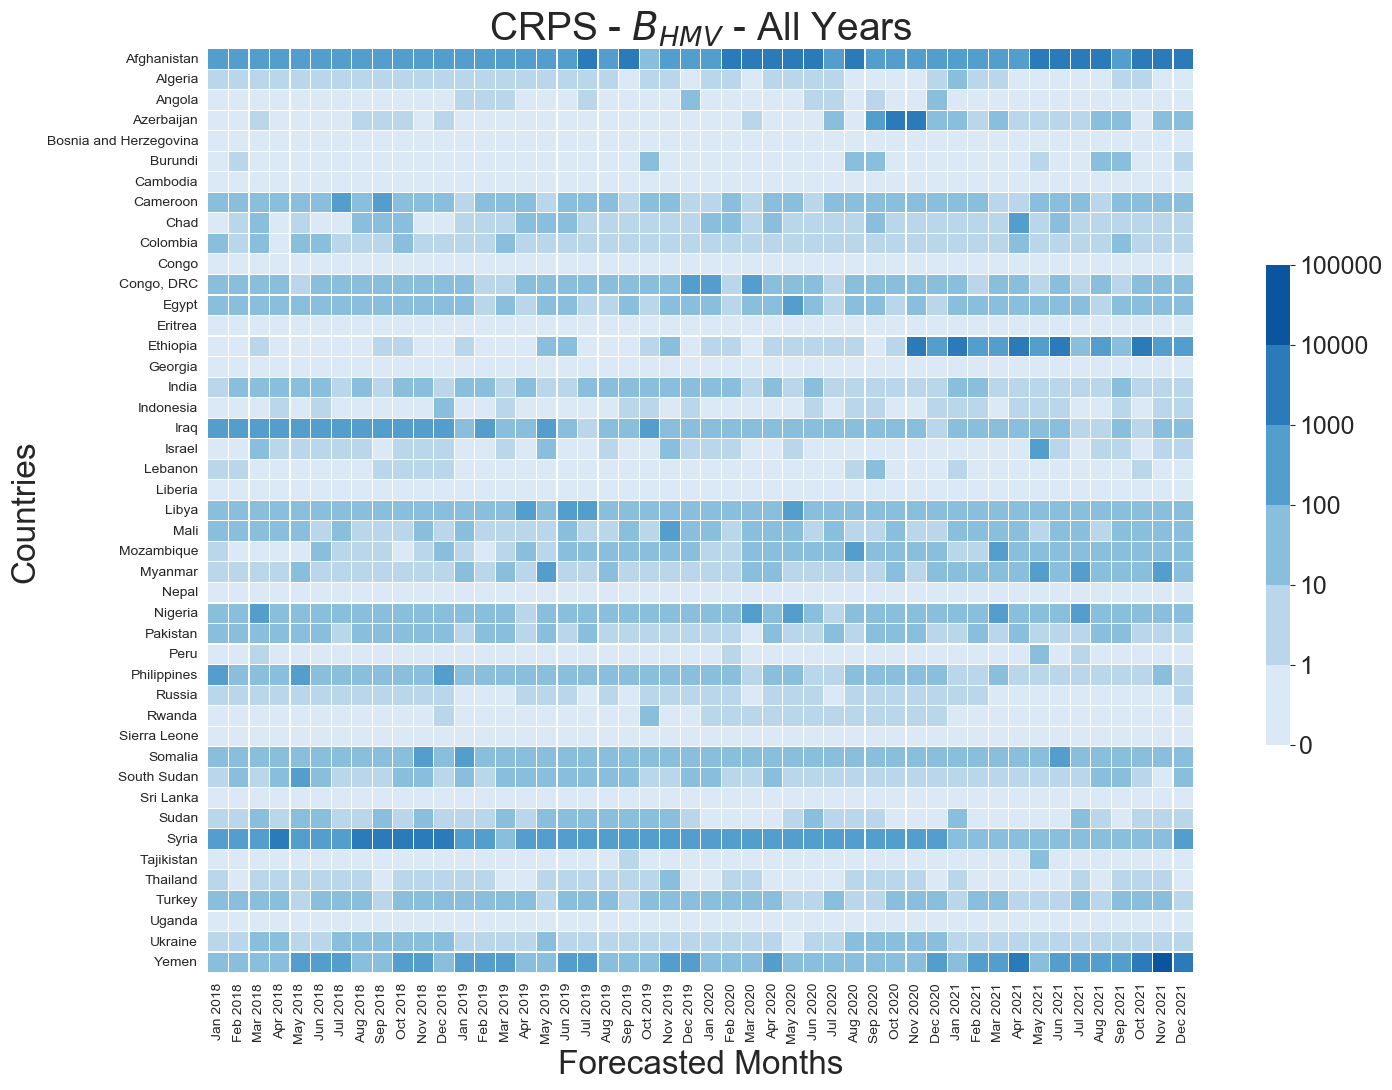

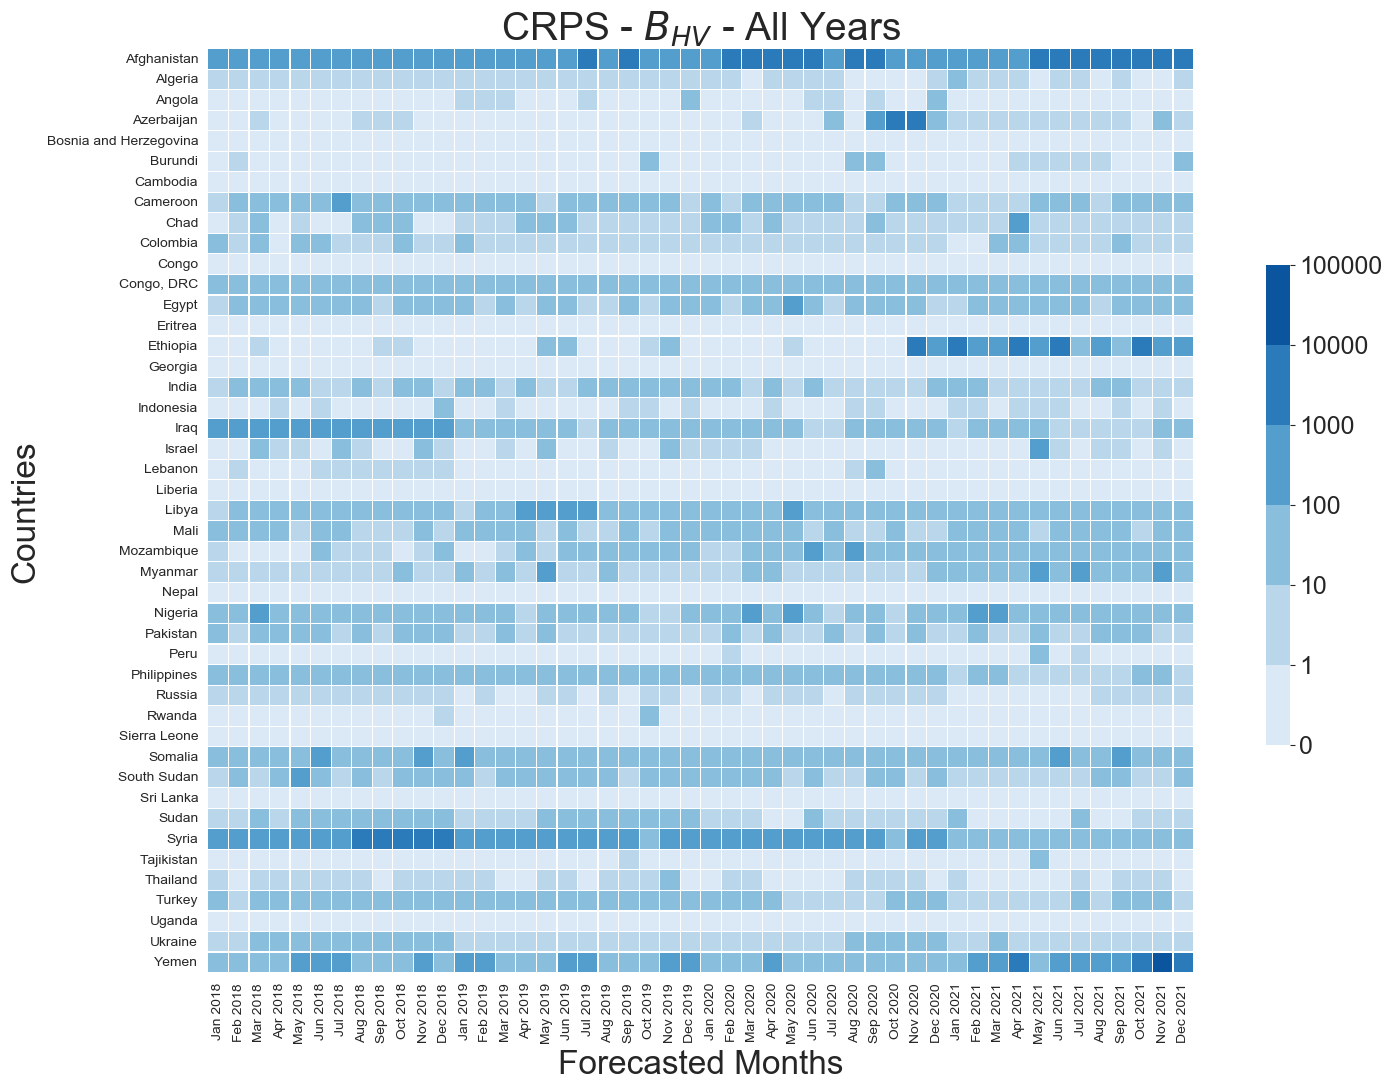

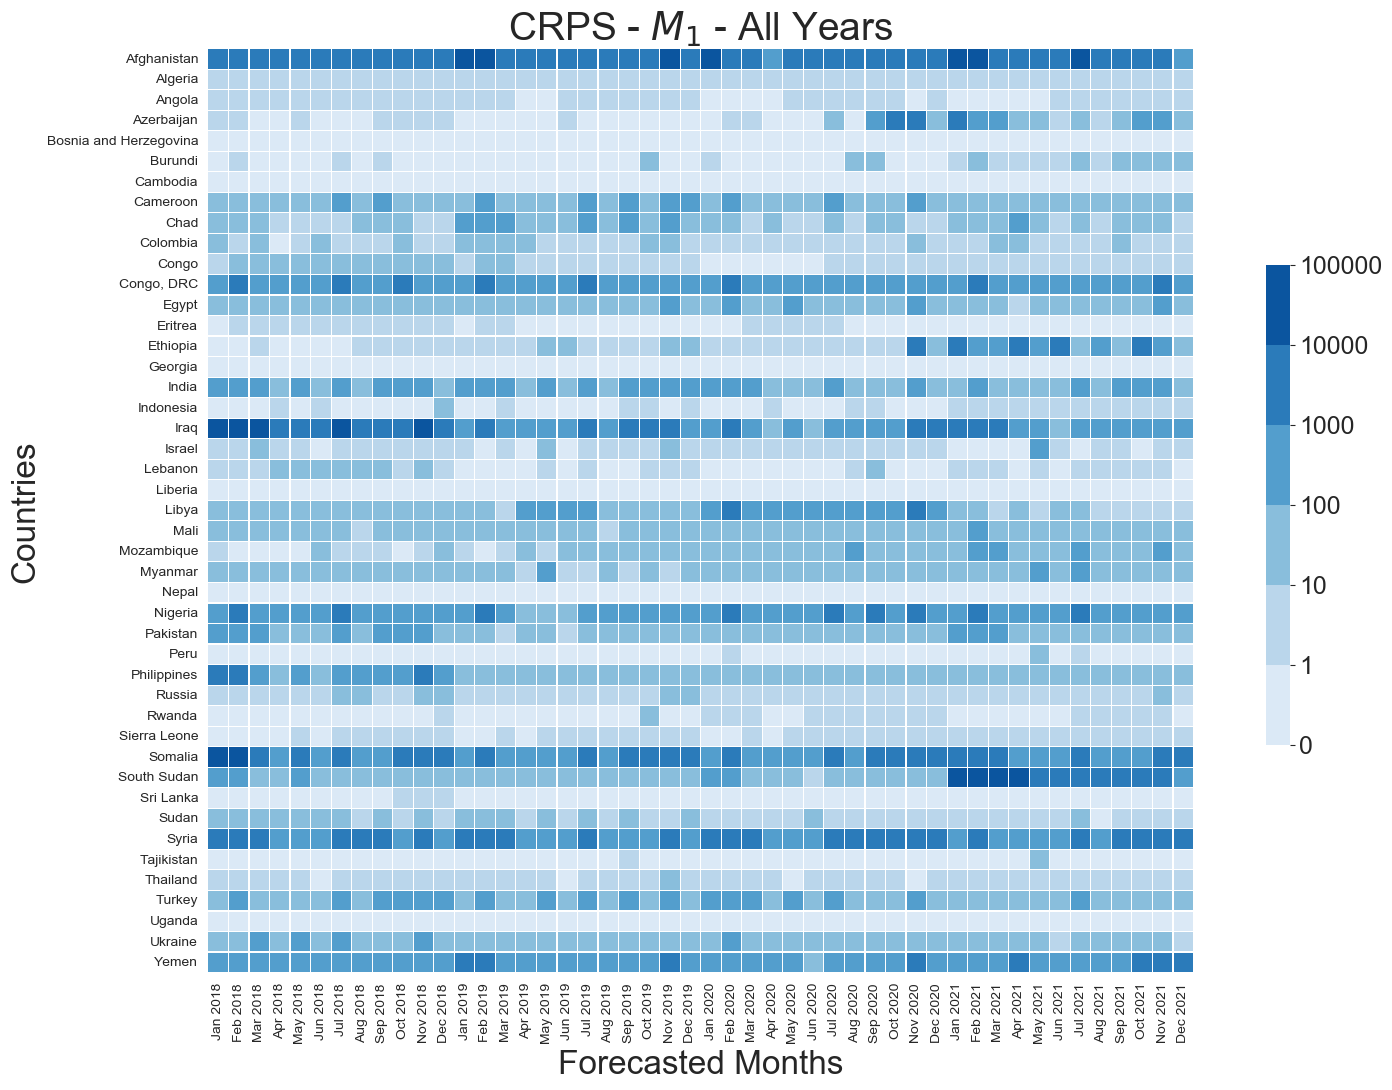

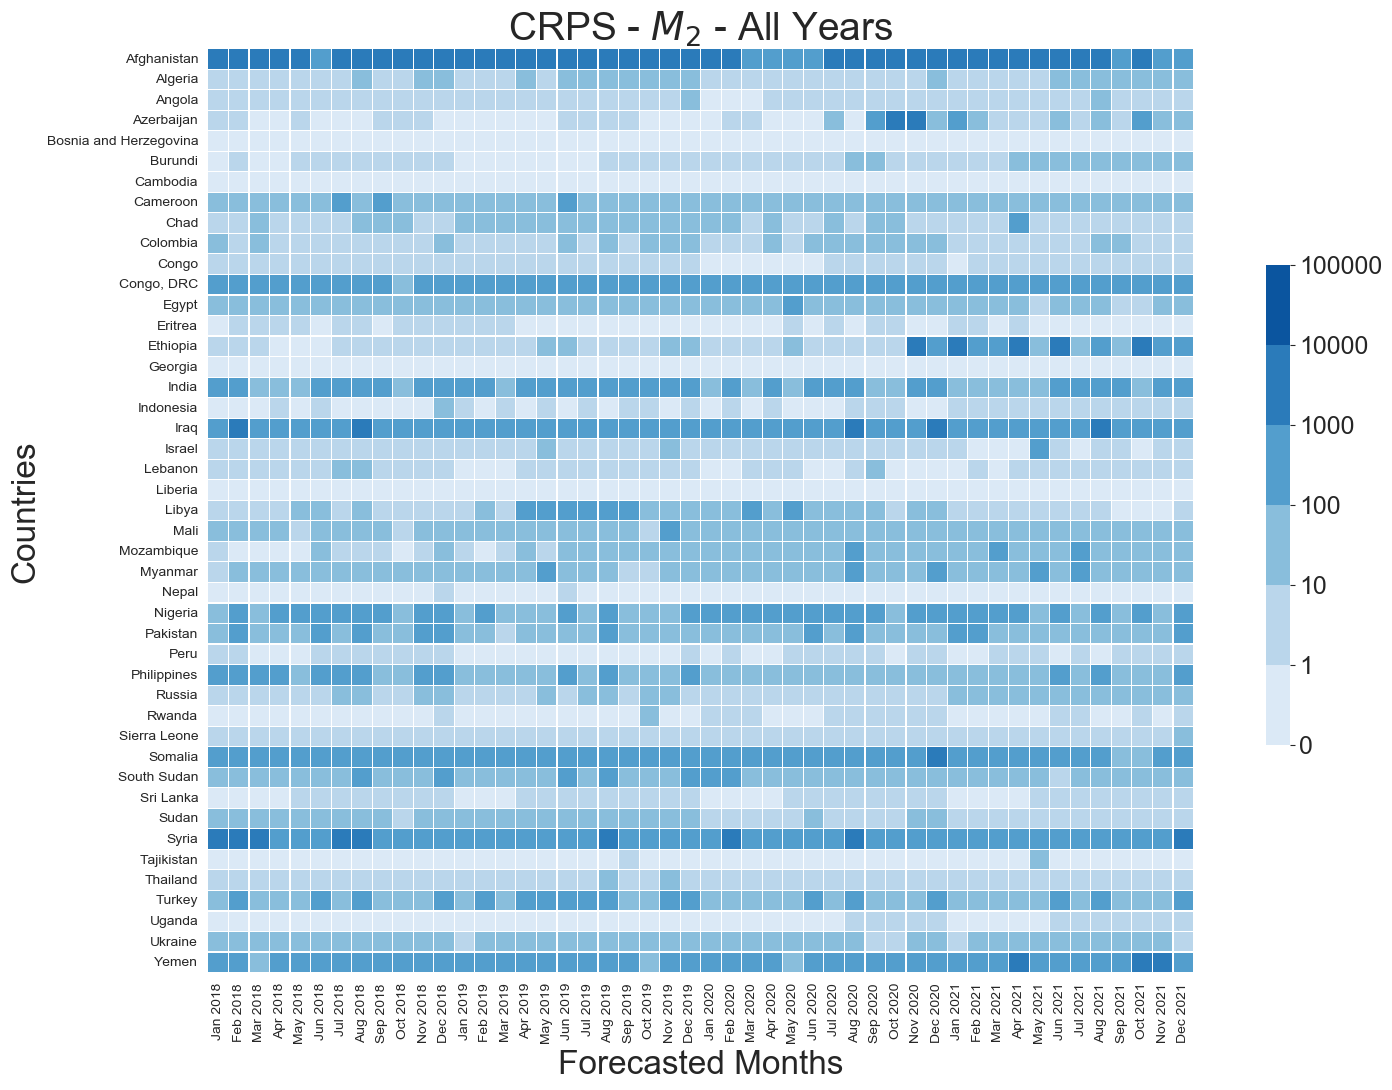

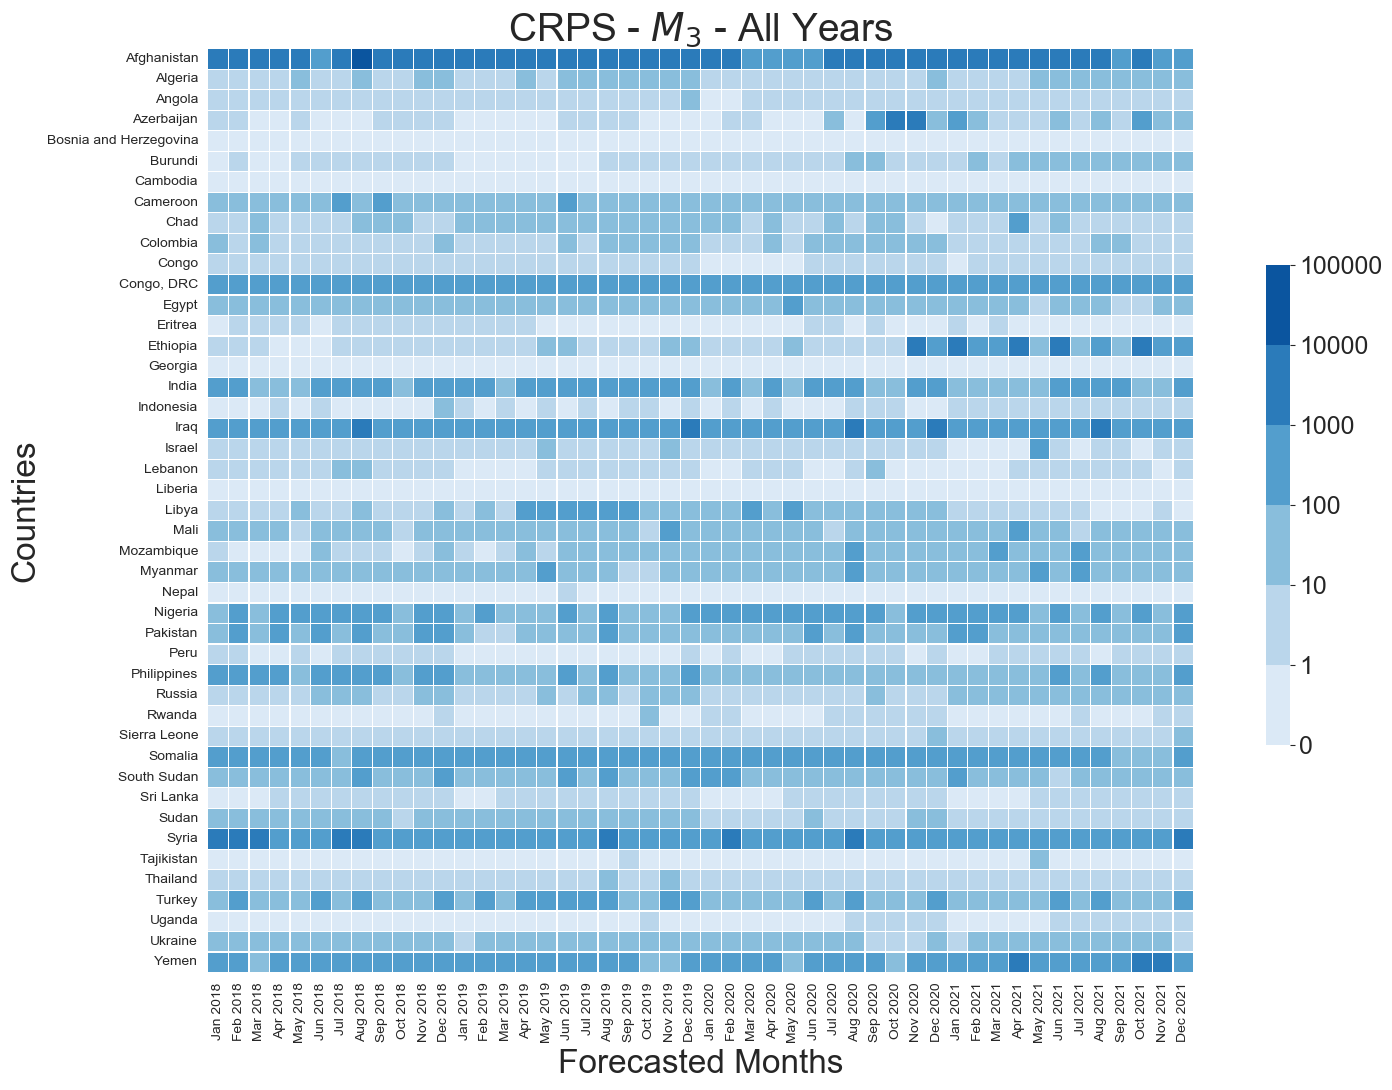

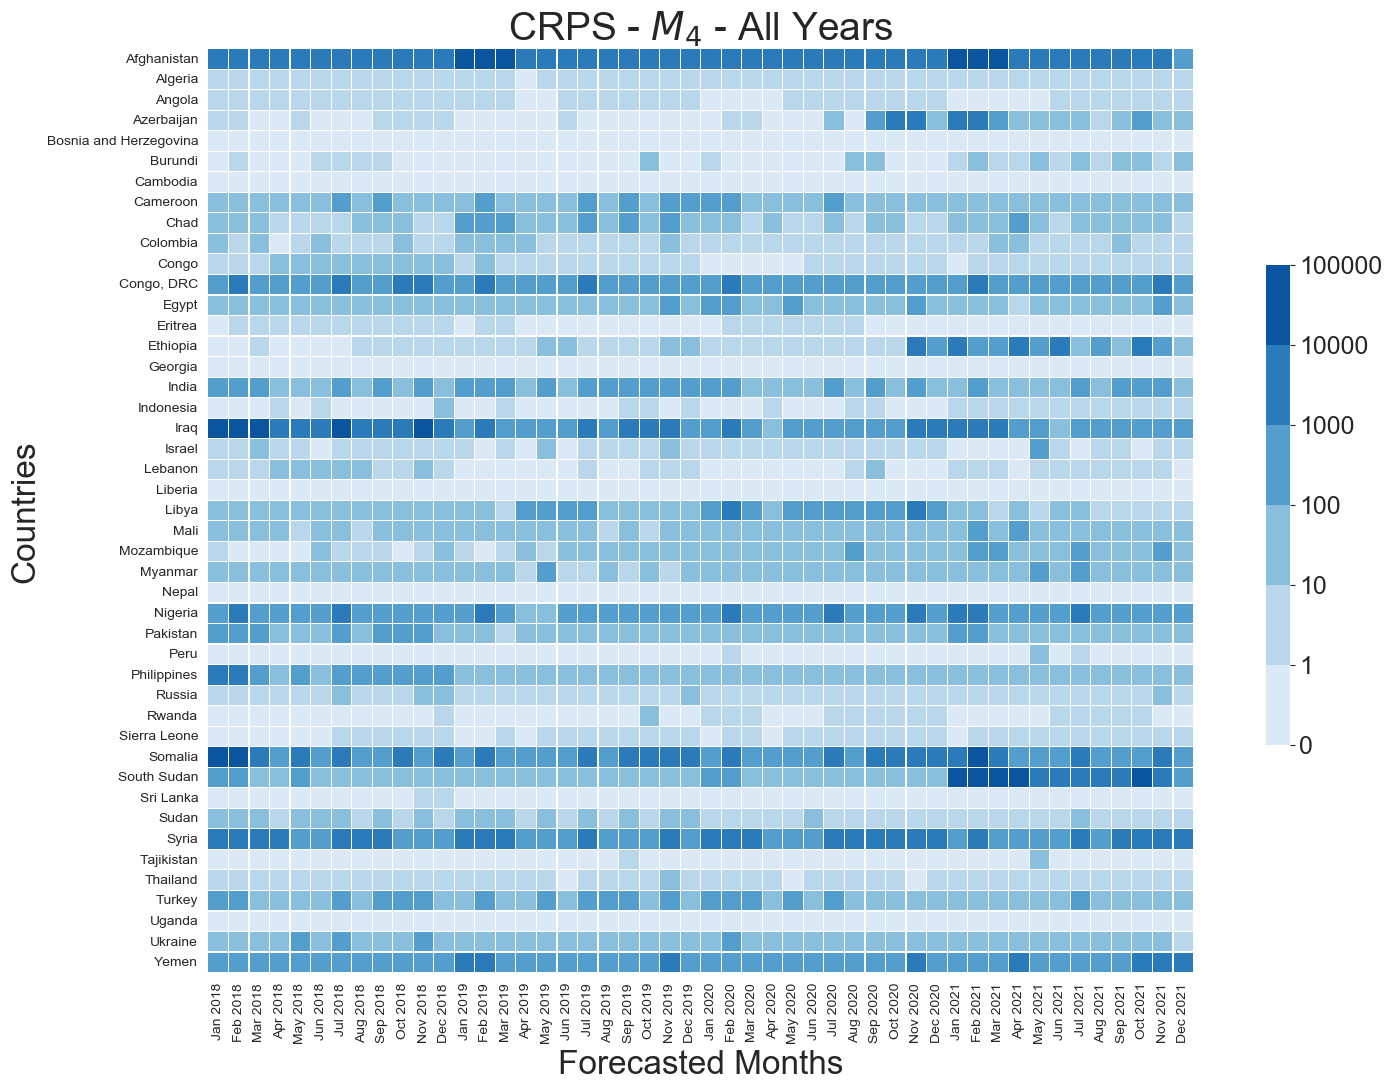

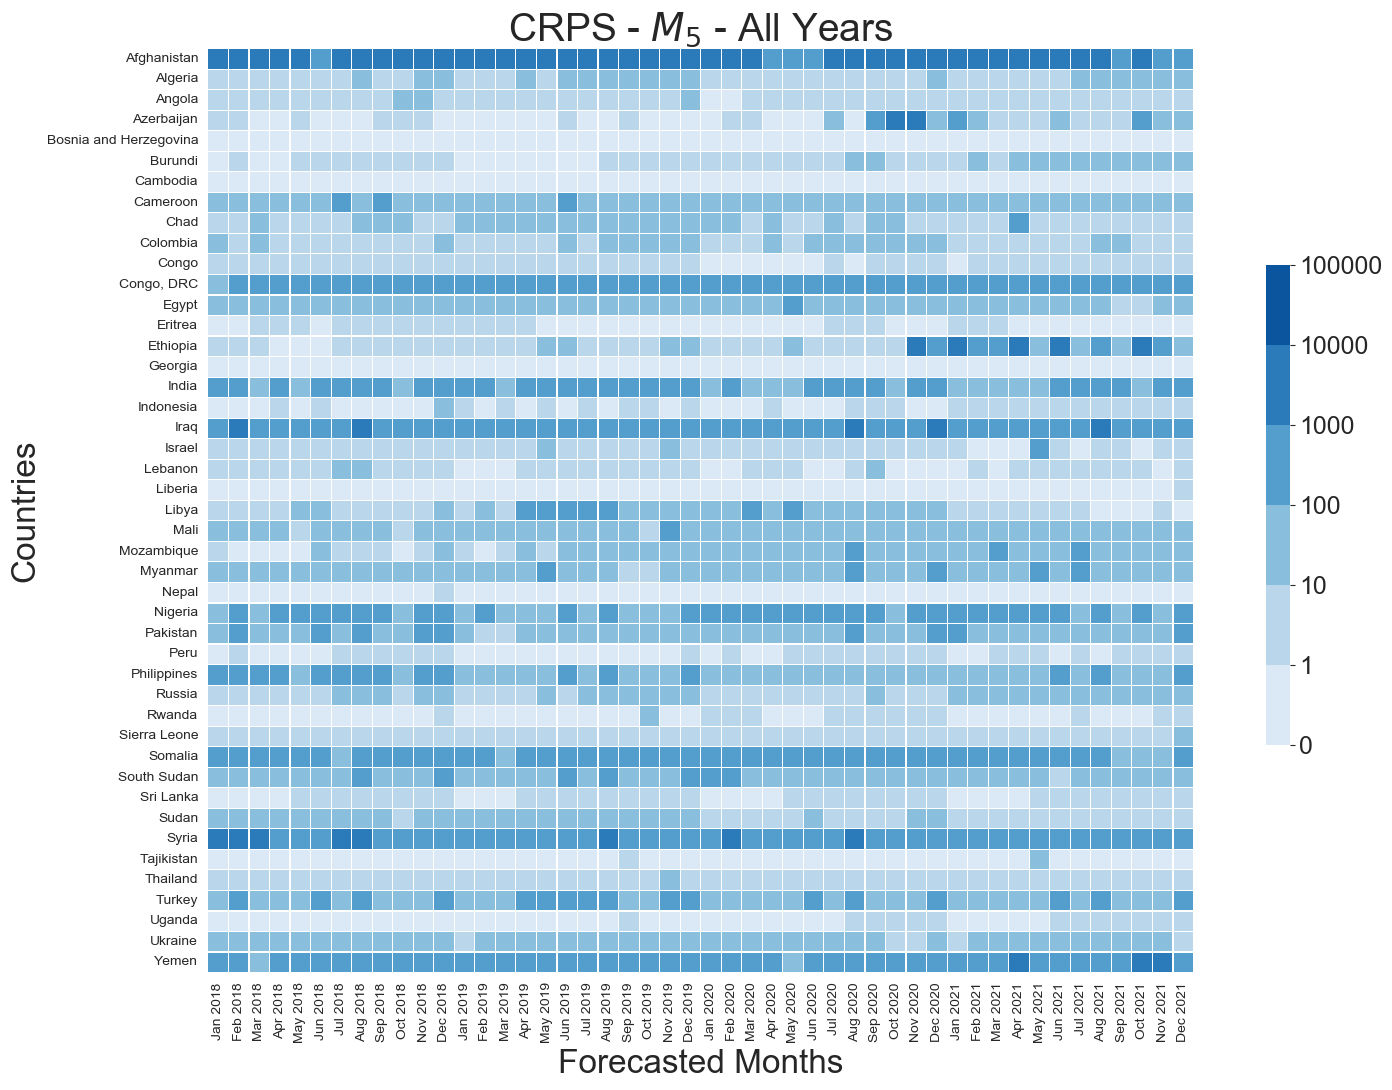

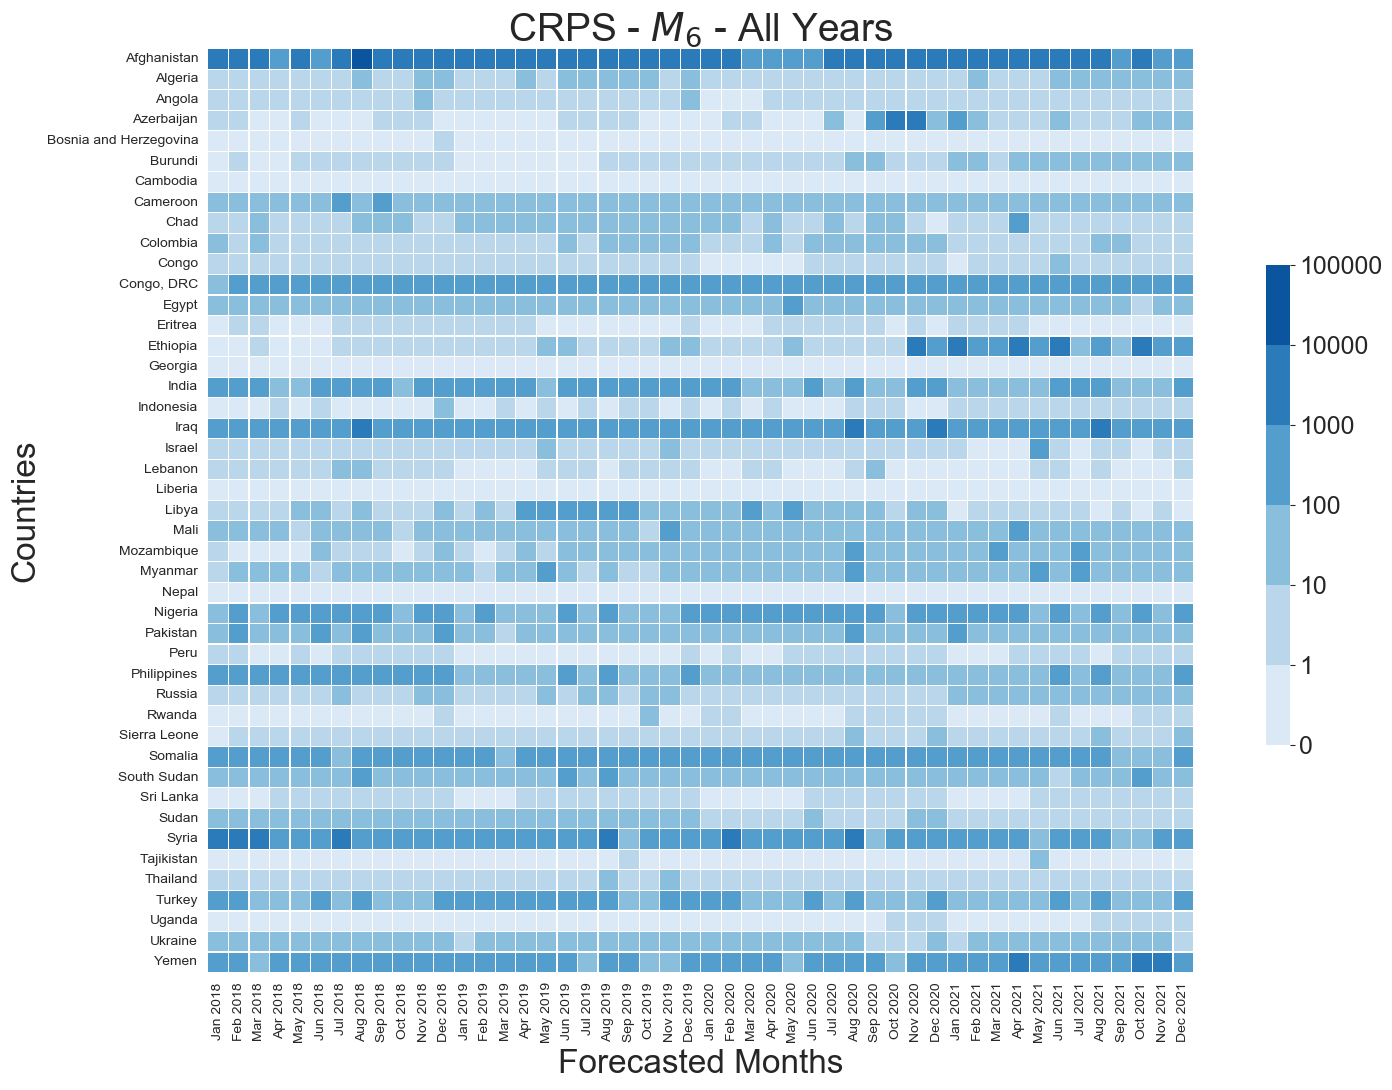

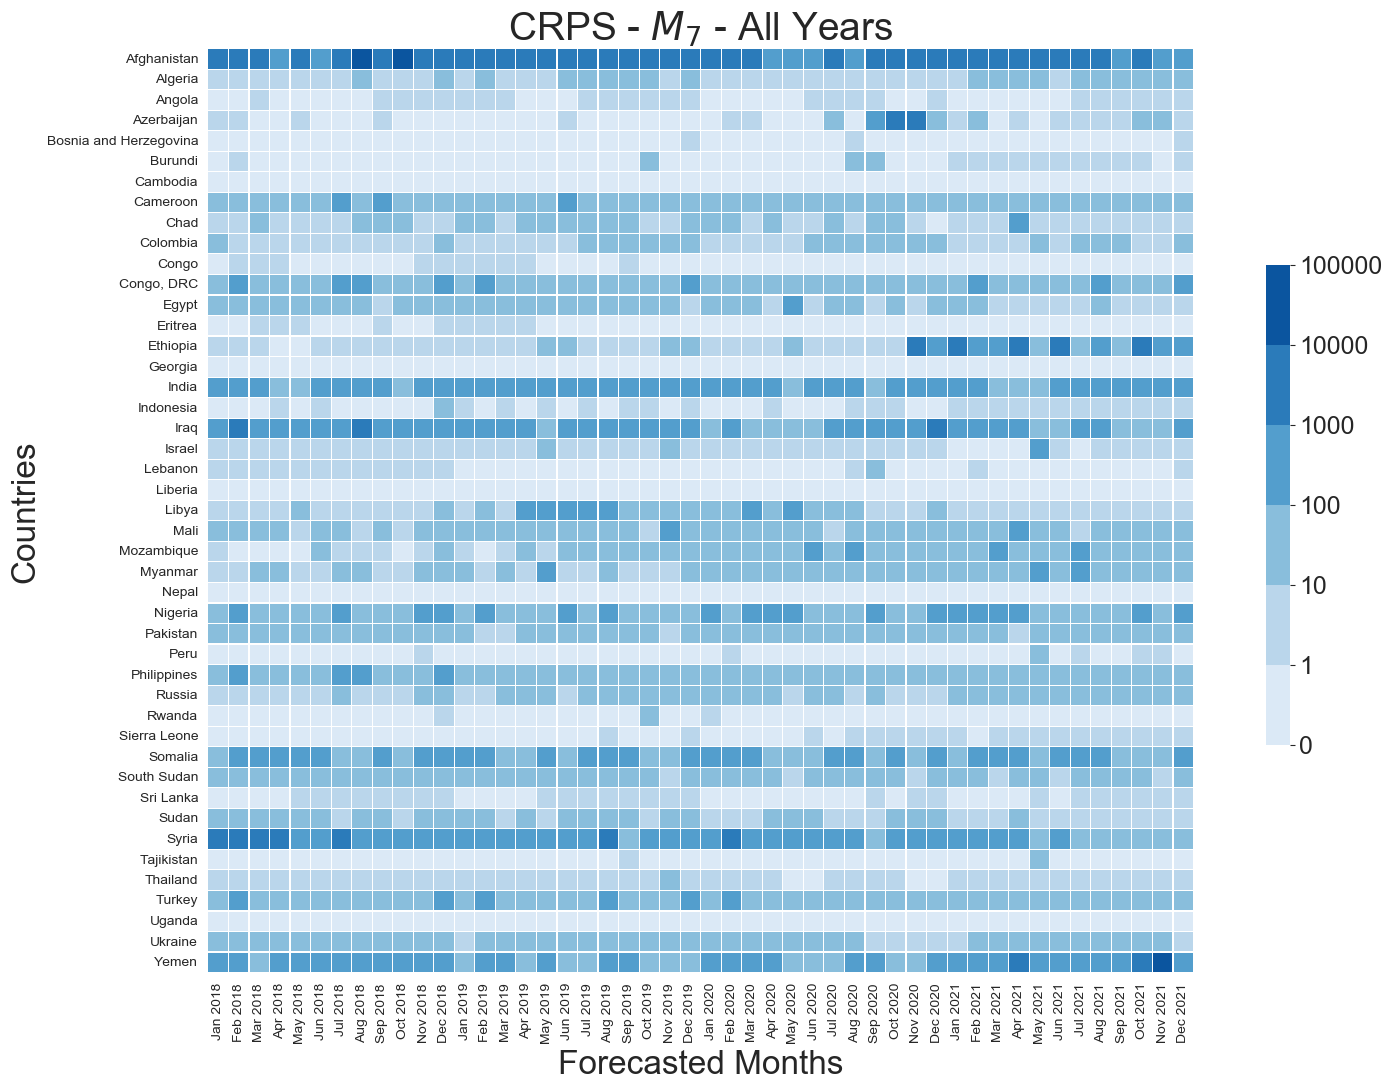

In [98]:
for heatmap_model, heatmap_model_scientific in zip(model_identifiers_all, model_scientific_identifiers_all):
    plot_heatmap(metrics, score_info[score_index], feature_and_actuals_countries_non_zero_above_avg_quantile, "subset_C",heatmap_model, heatmap_model_scientific, colors_heatmap, custom_scale=True, export=True)

In [26]:
for heatmap_model, heatmap_model_scientific in zip(model_identifiers_all, model_scientific_identifiers_all):
    plot_heatmap(metrics, score_info[score_index], feature_and_actuals_countries_non_zero, "subset_B",heatmap_model, heatmap_model_scientific, colors_heatmap, custom_scale=True, export=True)

KeyboardInterrupt: 

In [ ]:
for heatmap_model, heatmap_model_scientific in zip(model_identifiers_all, model_scientific_identifiers_all):
    plot_heatmap(metrics, score_info[score_index], feature_and_actuals_countries_non_zero, "subset_B",heatmap_model, heatmap_model_scientific, colors_heatmap, custom_scale=True, annotate_fat=True, export=True)

In [0]:
# Make an example for single model
heatmap_model = model_identifiers_all[6]
heatmap_model_scientific = model_scientific_identifiers_all[6]
plot_heatmap_fat(metrics, feature_and_actuals_countries_non_zero, 'subset_B', colors_heatmap, custom_scale=True, annotate_fat=True, export=True)

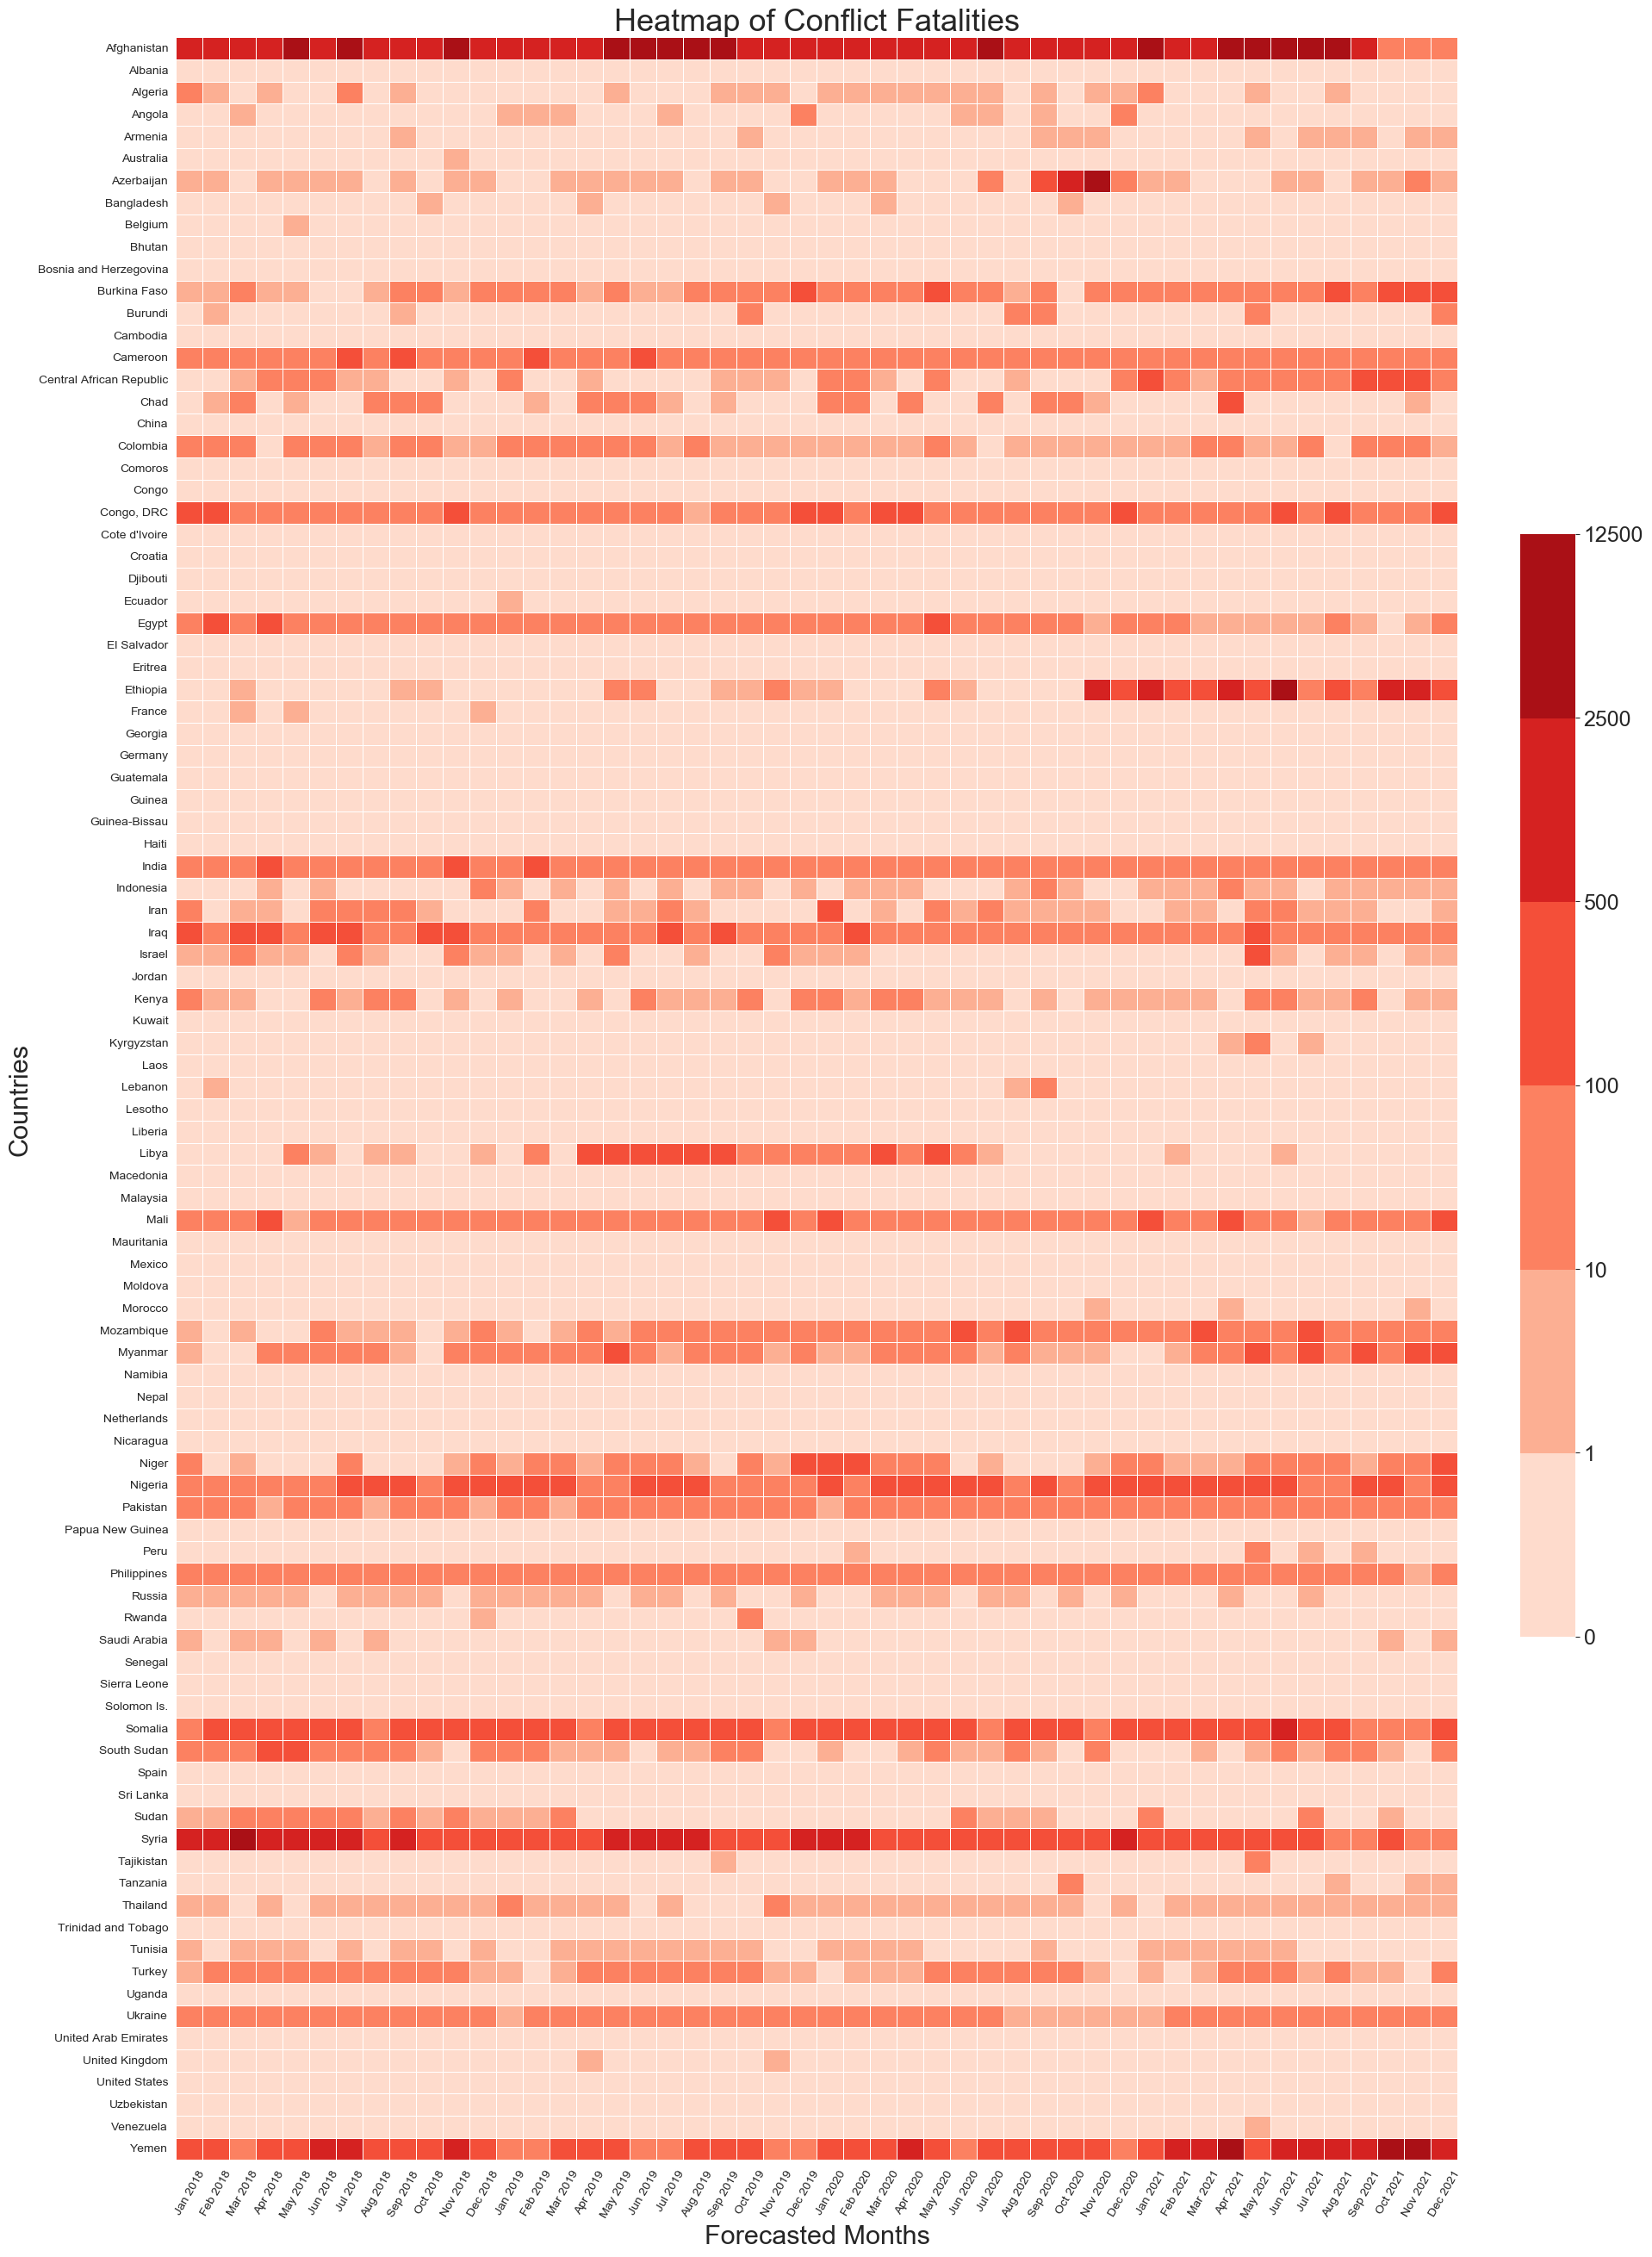

In [51]:
plot_heatmap_fat(metrics, feature_and_actuals_countries_non_zero, 'subset_B', colors_heatmap, custom_scale=True, export=True)

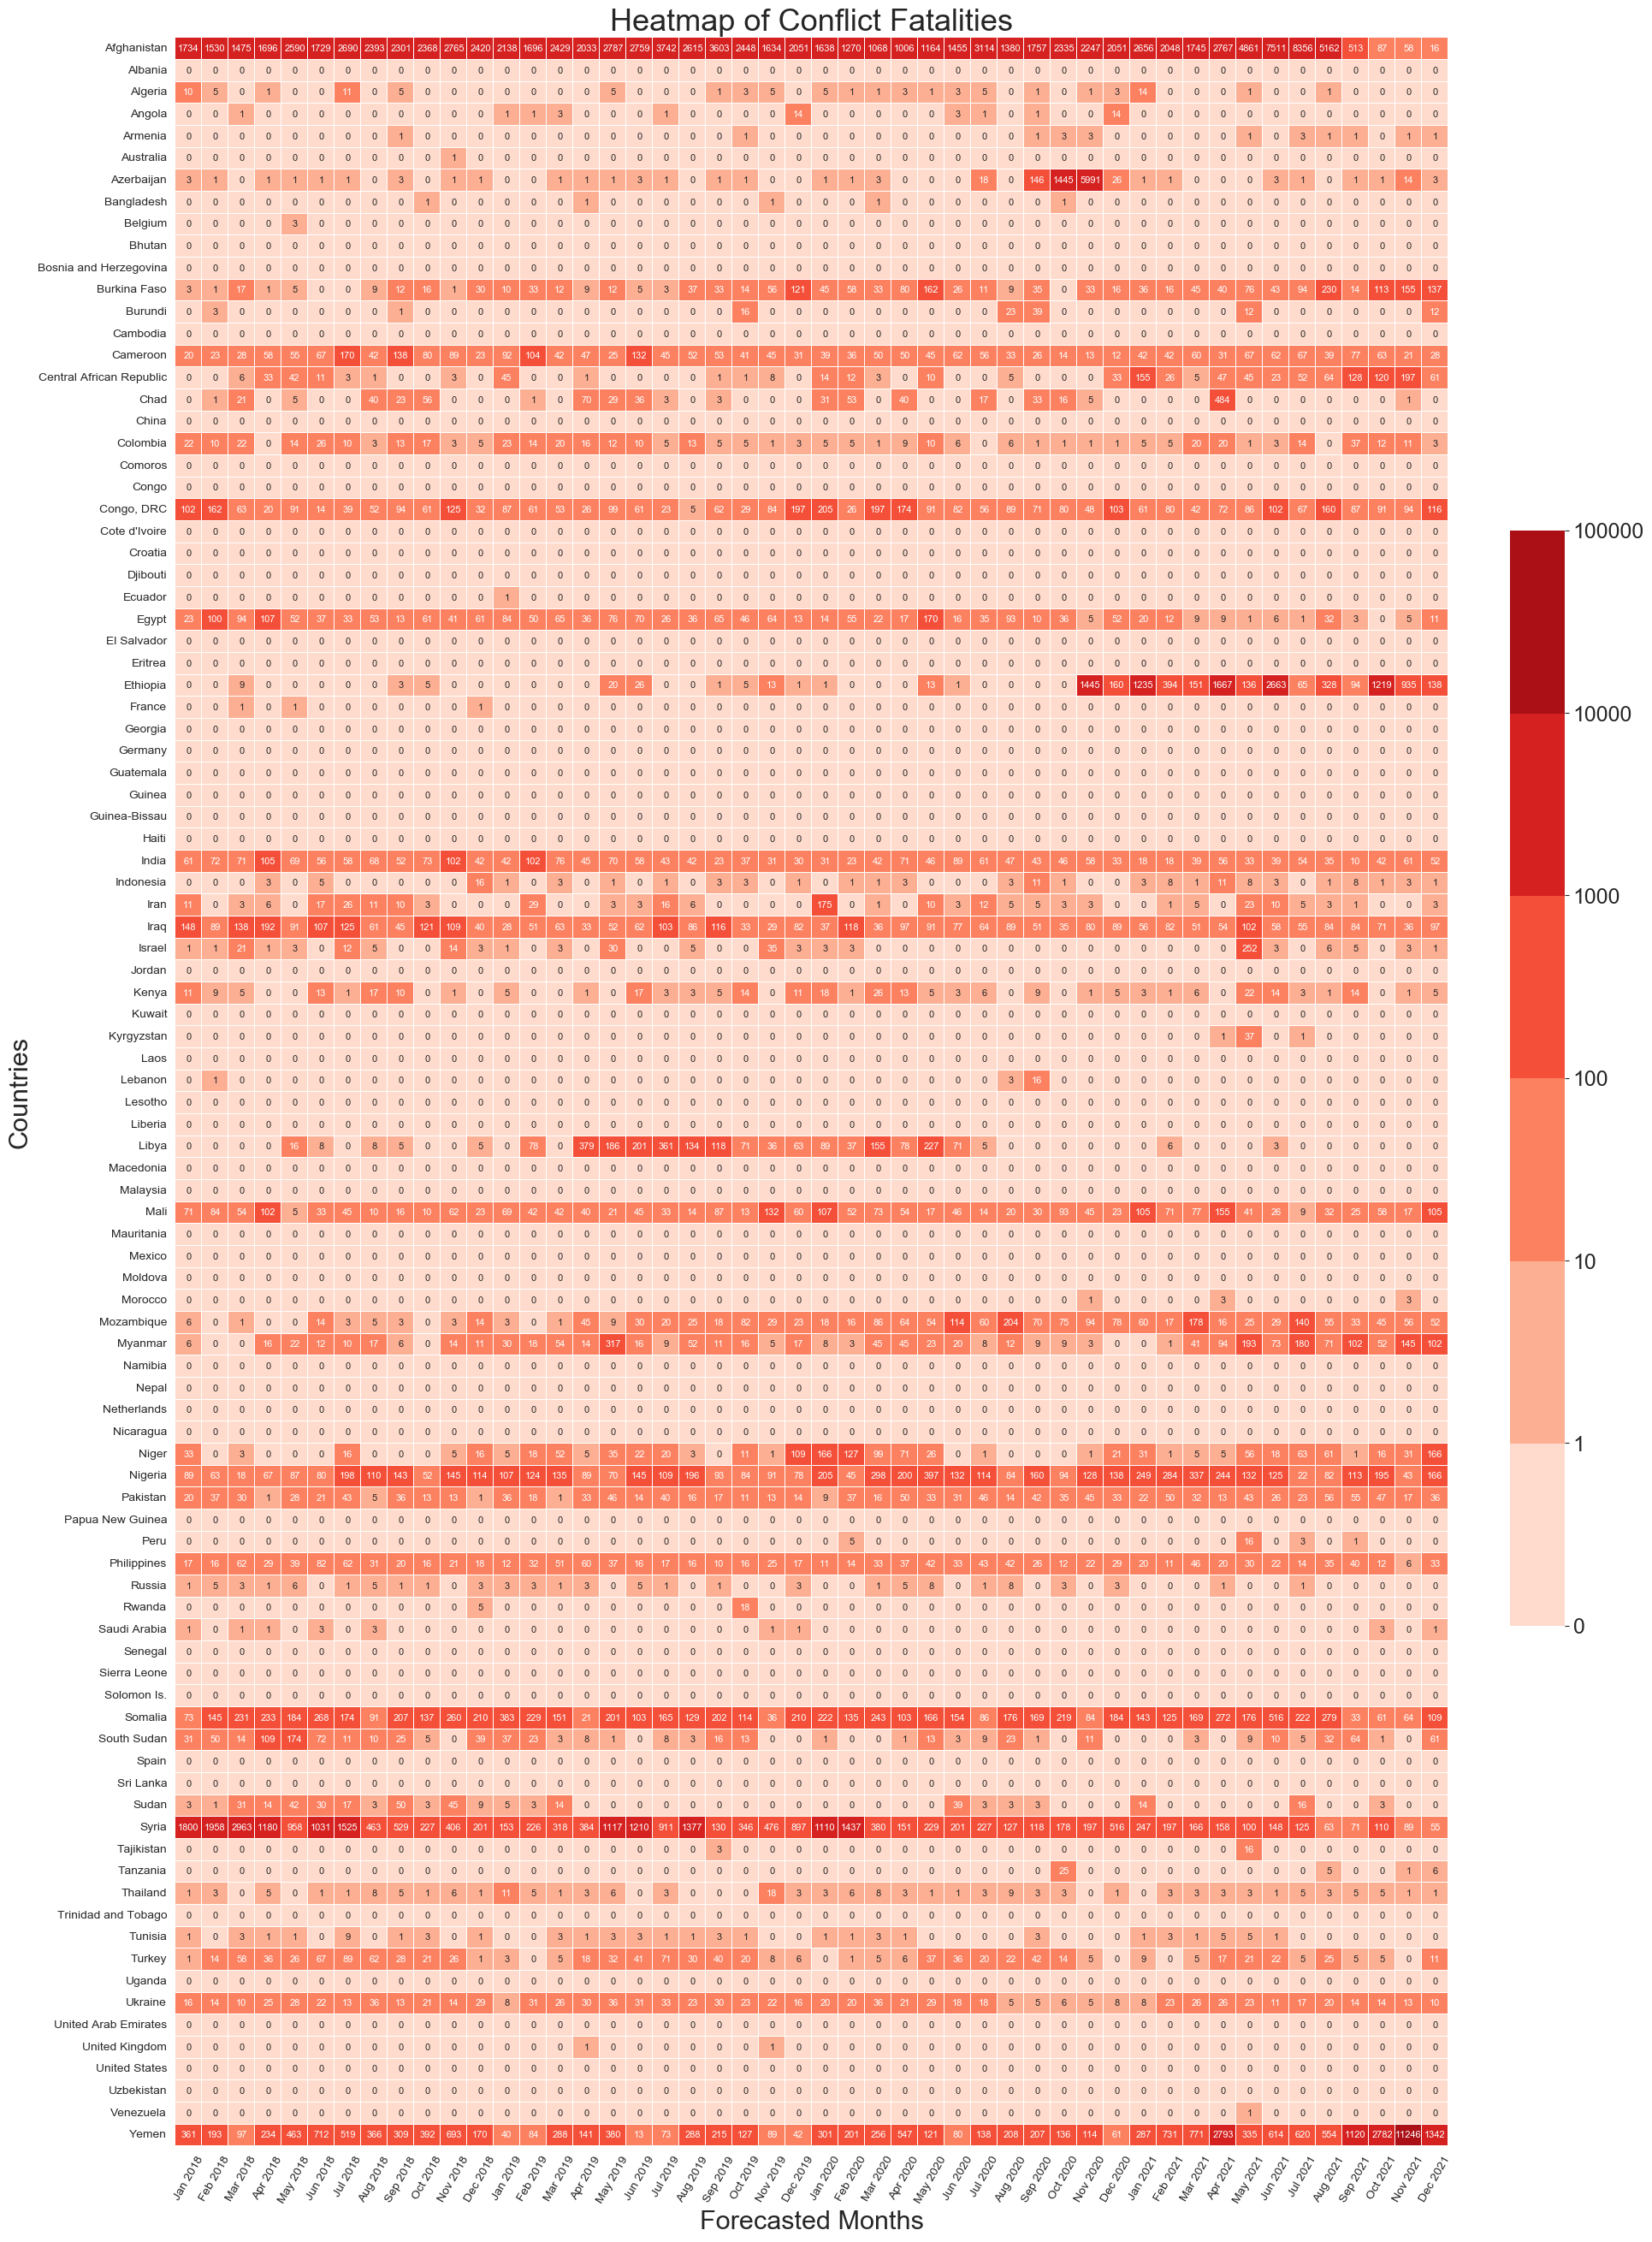

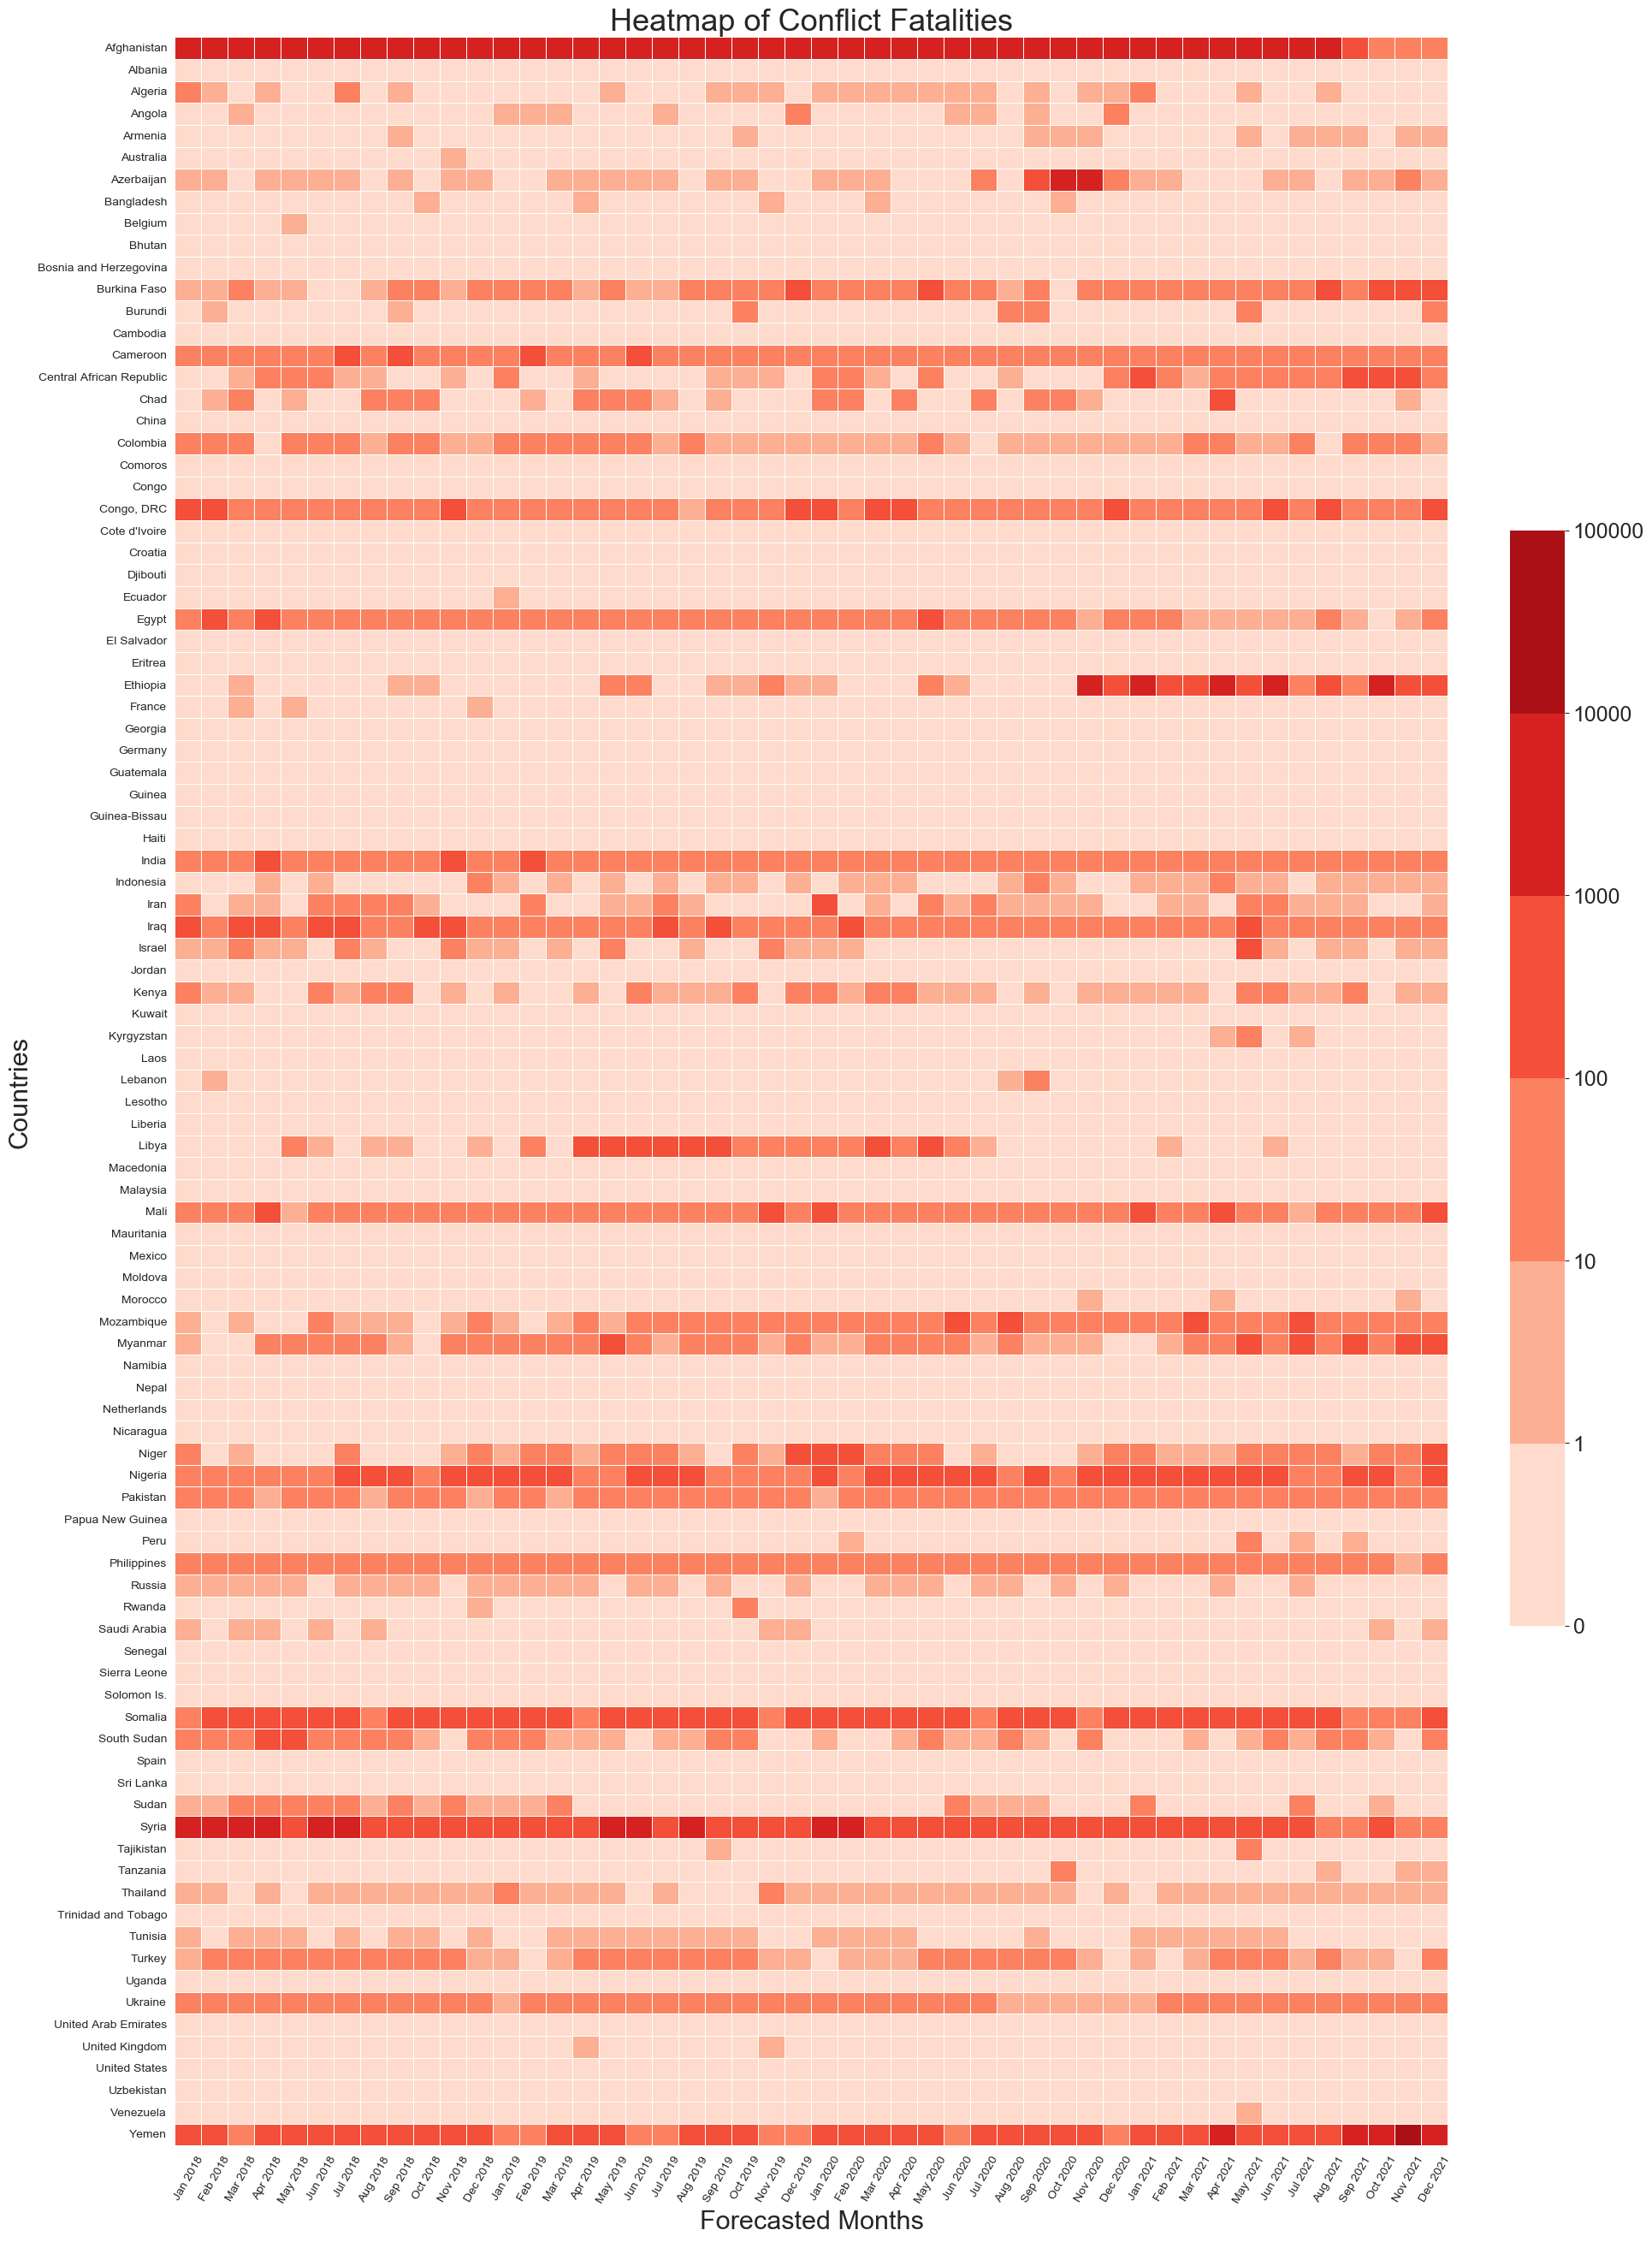

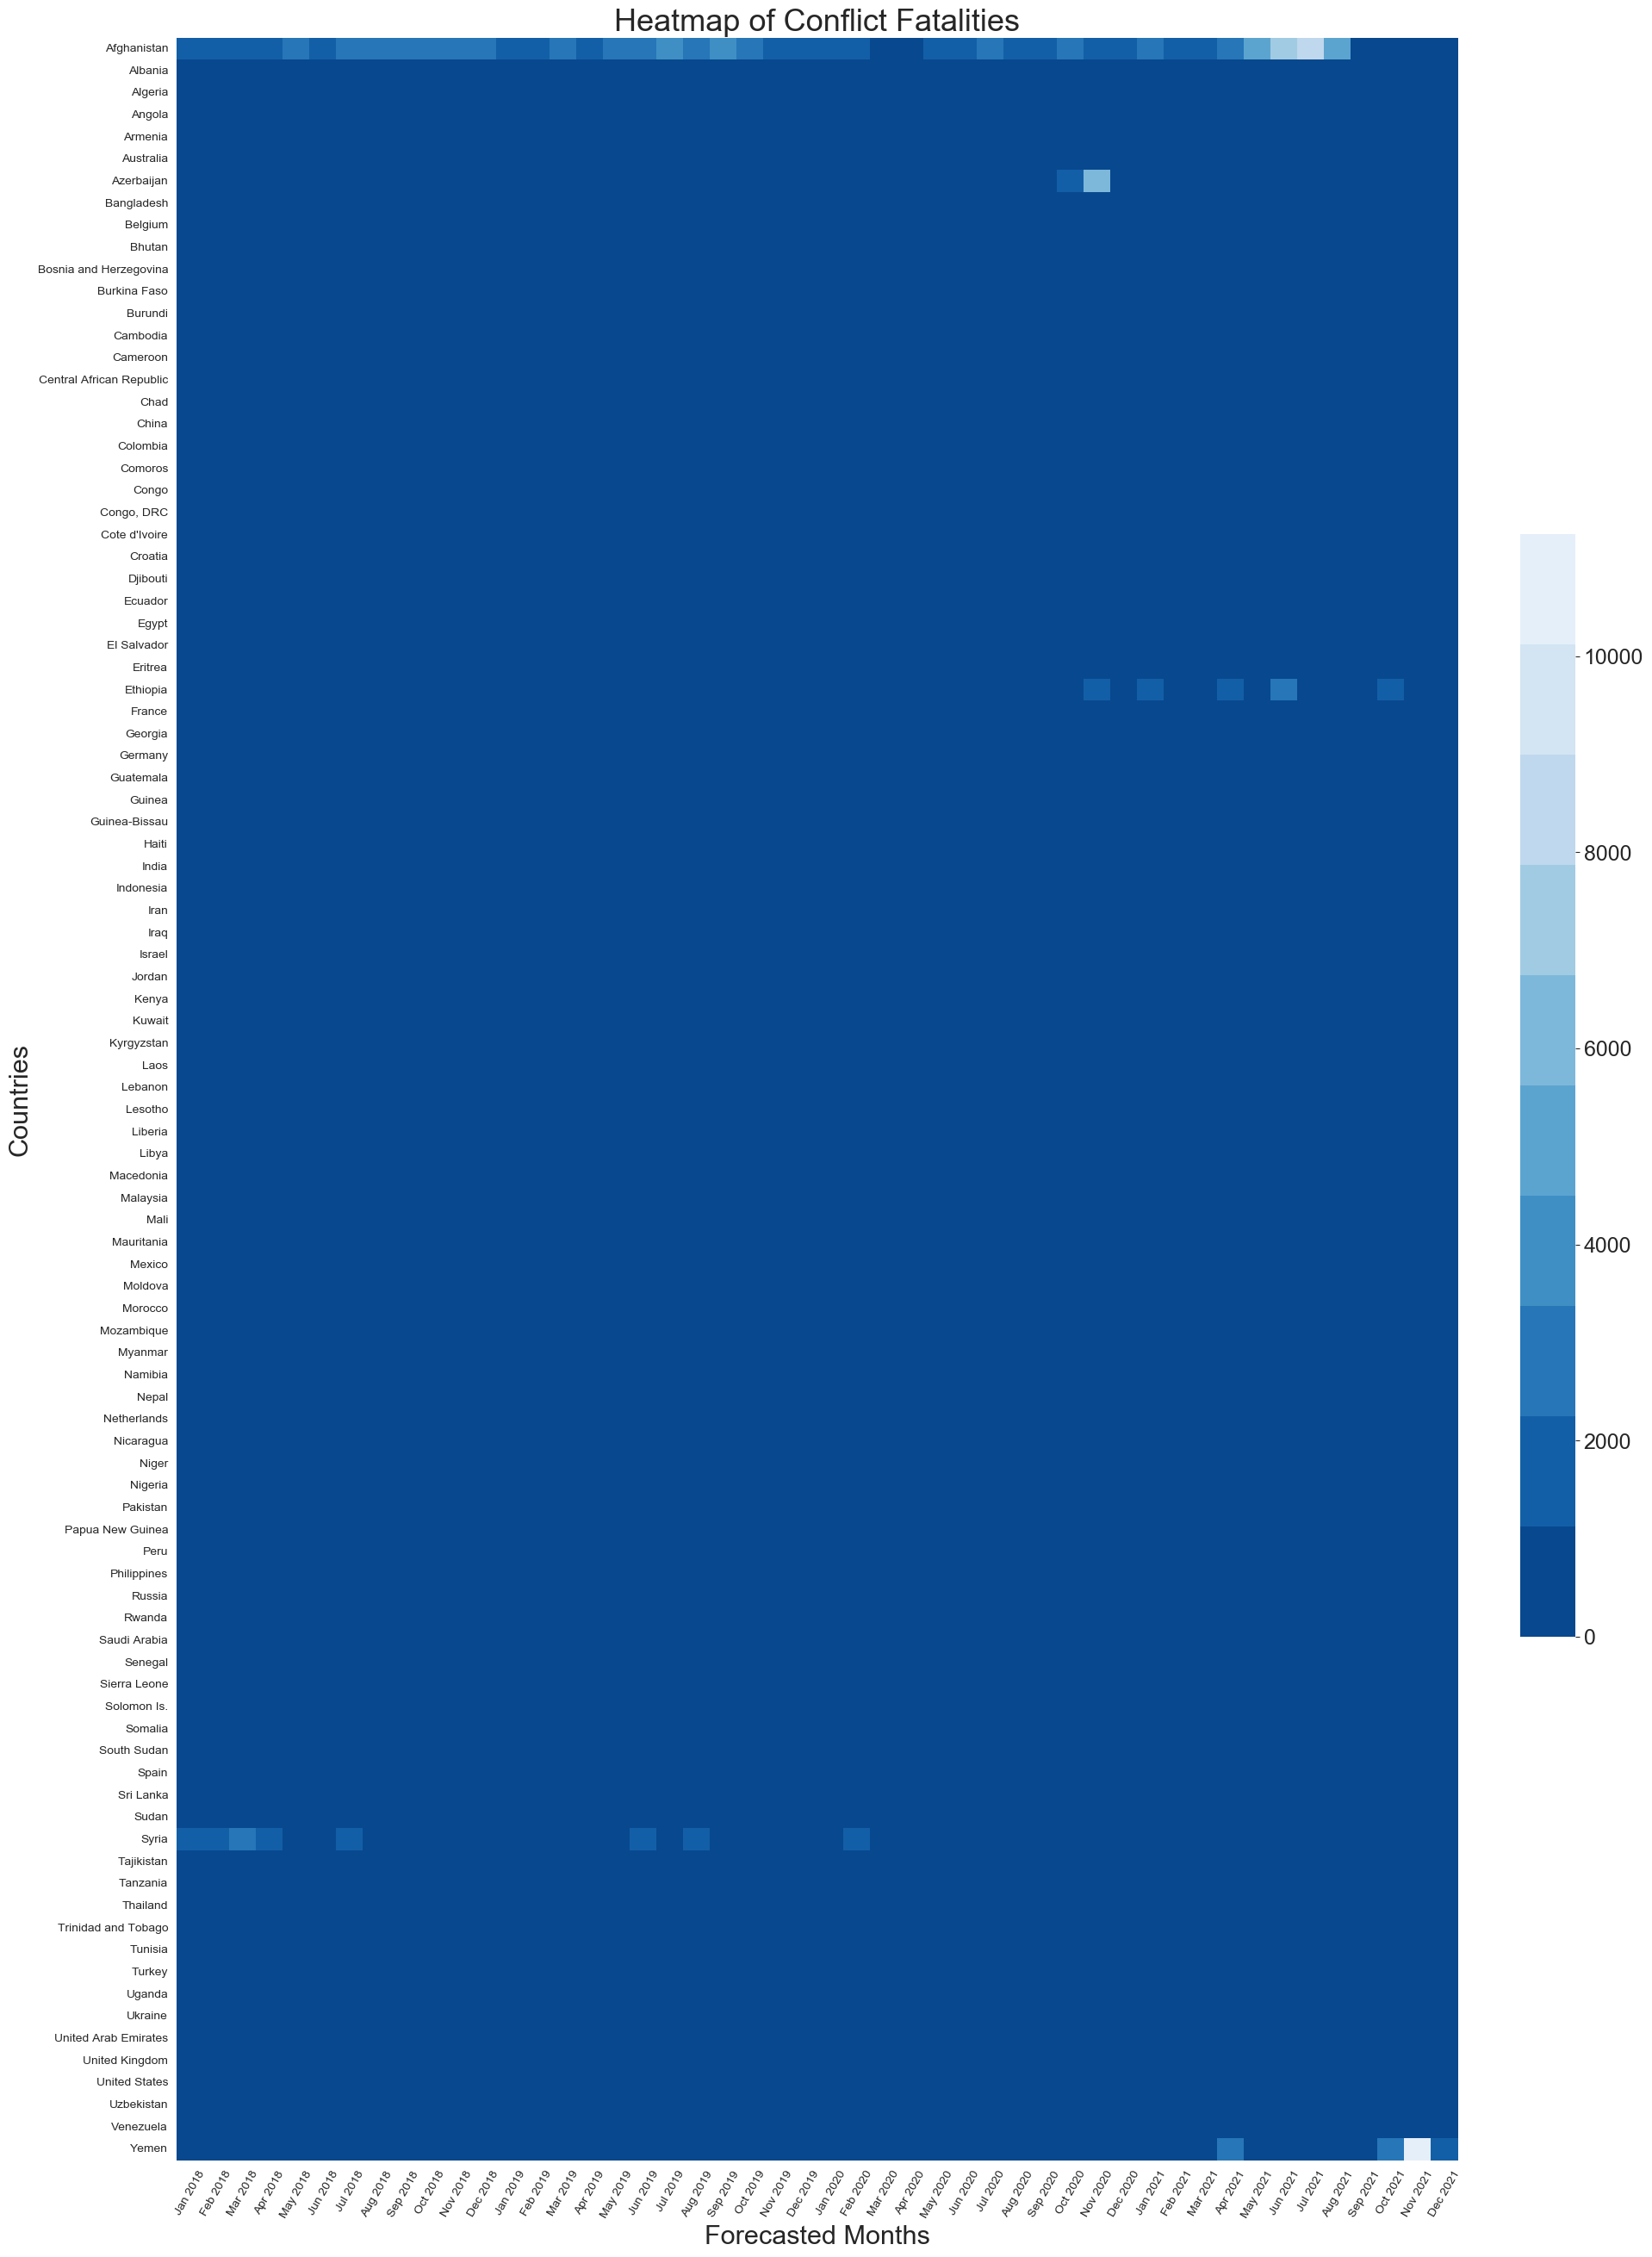

In [48]:
plot_heatmap_fat(metrics, feature_and_actuals_countries_non_zero, 'subset_B', colors_heatmap, export=True)

Heatmap with a custom scale that mimics a log scale but including 0 and with fatality annotations

In [ ]:
for country_list, country_list_name in zip([feature_and_actuals_countries_non_zero, feature_and_actuals_countries_non_zero_above_avg_quantile], ['subset_B', 'subset_C']):
    for heatmap_model, heatmap_model_scientific in zip(model_identifiers_all, model_scientific_identifiers_all):
        heatmap = plot_heatmap(metrics, score_info[score_index], country_list, country_list_name, heatmap_model, heatmap_model_scientific, colors_heatmap, custom_scale=True, annotate_fat=True, export=True)

**Line plot of error metrics**

In [28]:
color_string = 'deep'

In [29]:
score_index = 0

All models

In [ ]:
title = f'Average {score_info[score_index][1]} per Month'
plot_model_scores_scientific_labels(month_results_by_model, score_info[score_index][0], model_identifiers_all, model_scientific_identifiers_all, score_info[score_index][1], title, color_palette_str=color_string)

Subset of models

In [26]:
metrics

,country_id,month_id,crps,interval_score,ignorance_score,model_identifier,ged_sb
0,1,457,0.000000,0.00,0.137504,baseline_f_m,0.0
1,1,458,0.000000,0.00,0.137504,baseline_f_m,0.0
2,1,459,0.000000,0.00,0.137504,baseline_f_m,0.0
3,1,460,0.000000,0.00,0.137504,baseline_f_m,0.0
4,1,461,0.000000,0.00,0.137504,baseline_f_m,0.0
...,...,...,...,...,...,...,...
82507,246,500,50.674614,1172.15,4.004788,model7,32.0
82508,246,501,71.253514,3059.65,3.811642,model7,65.0
82509,246,502,74.317686,4002.85,3.811642,model7,2.0
82510,246,503,9.231217,388.25,1.518043,model7,0.0


In [61]:
# Export dataframe month_results_by_model as parquet File
export_path = 'C:/Users/Uwe Drauz/Documents/bachelor_thesis_local/personal_competition_data/Plots/plot_data'
# FIlter data on "baseline_f_m" and " baseline_f" for model as well as crps for score type
month_results_by_model_export = month_results_by_model[((month_results_by_model['model'] == 'baseline_f_m') | (month_results_by_model['model'] == 'baseline_f') | (month_results_by_model['model'] == 'model7')) & (month_results_by_model['score_type'] == 'crps')]
month_results_by_model_export

,model,score_type,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,baseline_f_m,crps,2018,8.468459,10.648134,11.783207,12.686872,13.676324,10.623760,10.326816,17.804988,13.686510,15.539773,19.644967,19.253406
1,baseline_f_m,crps,2019,7.676698,4.888777,4.300734,6.134396,7.435876,6.989421,11.197865,5.807473,10.423314,4.904547,5.334228,7.217085
2,baseline_f_m,crps,2020,7.296156,11.158203,11.898919,13.822480,15.019865,10.986405,3.910014,12.619742,11.083357,13.941198,44.561055,4.794415
3,baseline_f_m,crps,2021,11.778065,6.932708,8.233732,28.833992,19.836503,47.431630,37.369144,22.290593,13.347532,29.056223,75.737114,20.655081
12,baseline_f,crps,2018,7.375737,7.299127,10.960114,9.921667,14.025641,11.164810,11.097284,15.175744,14.337950,21.675014,17.870073,17.001255
13,baseline_f,crps,2019,8.902918,6.834670,6.072614,6.899781,7.621479,7.684259,10.926198,6.823222,9.973632,4.648437,5.443769,5.904654
14,baseline_f,crps,2020,10.273204,11.683646,11.192417,12.615947,12.927953,10.841579,4.856882,11.402559,10.332871,10.587618,44.340886,6.168383
15,baseline_f,crps,2021,13.264905,8.086865,6.237588,32.076374,21.633342,48.041654,37.773274,21.960023,14.347071,30.143841,74.495773,17.808559
96,model7,crps,2018,22.869323,42.025999,25.602842,17.670286,19.396861,17.831789,27.301308,128.873454,15.553689,75.872298,20.193249,22.126394
97,model7,crps,2019,14.905660,21.036584,16.685802,14.647874,22.044520,20.643613,25.737964,47.524684,17.468702,31.747774,13.869490,24.920872


In [65]:
baseline_data_df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,model
0,8.468459,10.648134,11.783207,12.686872,13.676324,10.623760,10.326816,17.804988,13.686510,15.539773,...,28.833992,19.836503,47.431630,37.369144,22.290593,13.347532,29.056223,75.737114,20.655081,baseline_f_m
1,7.375737,7.299127,10.960114,9.921667,14.025641,11.164810,11.097284,15.175744,14.337950,21.675014,...,32.076374,21.633342,48.041654,37.773274,21.960023,14.347071,30.143841,74.495773,17.808559,baseline_f
2,22.869323,42.025999,25.602842,17.670286,19.396861,17.831789,27.301308,128.873454,15.553689,75.872298,...,38.702680,28.459080,51.205733,46.021329,46.619111,13.296882,40.576061,67.983312,18.806443,model7


In [66]:
month_results_by_model_export.to_parquet(f'{export_path}/data_crps_line_plot.parquet')

In [62]:
baseline_f_m_data = month_results_by_model_export[month_results_by_model_export['model'] == 'baseline_f_m'].drop('model', axis=1).drop('score_type', axis=1).drop('year', axis=1)
baseline_f_data = month_results_by_model_export[month_results_by_model_export['model'] == 'baseline_f'].drop('model', axis=1).drop('score_type', axis=1).drop('year', axis=1)
model7_data = month_results_by_model_export[month_results_by_model_export['model'] == 'model7'].drop('model', axis=1).drop('score_type', axis=1).drop('year', axis=1)

In [63]:
# Transform to numpy array
baseline_f_m_data_np = baseline_f_m_data.to_numpy()
baseline_f_data_np = baseline_f_data.to_numpy()
model7_data_np = model7_data.to_numpy()

In [64]:
# Flatten numpy array and reshape
baseline_f_m_data_np.flatten()
baseline_f_m_data_np = baseline_f_m_data_np.reshape(1, 48)
baseline_f_data_np.flatten()
baseline_f_data_np = baseline_f_data_np.reshape(1, 48)
model7_data_np.flatten()
model7_data_np = model7_data_np.reshape(1, 48)

# Put them together in a new dataframe
baseline_f_m_data_df = pd.DataFrame(baseline_f_m_data_np)
baseline_f_data_df = pd.DataFrame(baseline_f_data_np)
model7_data_df = pd.DataFrame(model7_data_np)

# Concatenate the two dataframes 
baseline_data_df = pd.concat([baseline_f_m_data_df, baseline_f_data_df, model7_data_df], ignore_index=True)
# Put a model identifier as first column
baseline_data_df['model'] = ['baseline_f_m', 'baseline_f', 'model7']

# Export the dataframe as csv
baseline_data_df.to_csv(f'{export_path}/data_crps_line_plot_reshaped.csv', index=False)

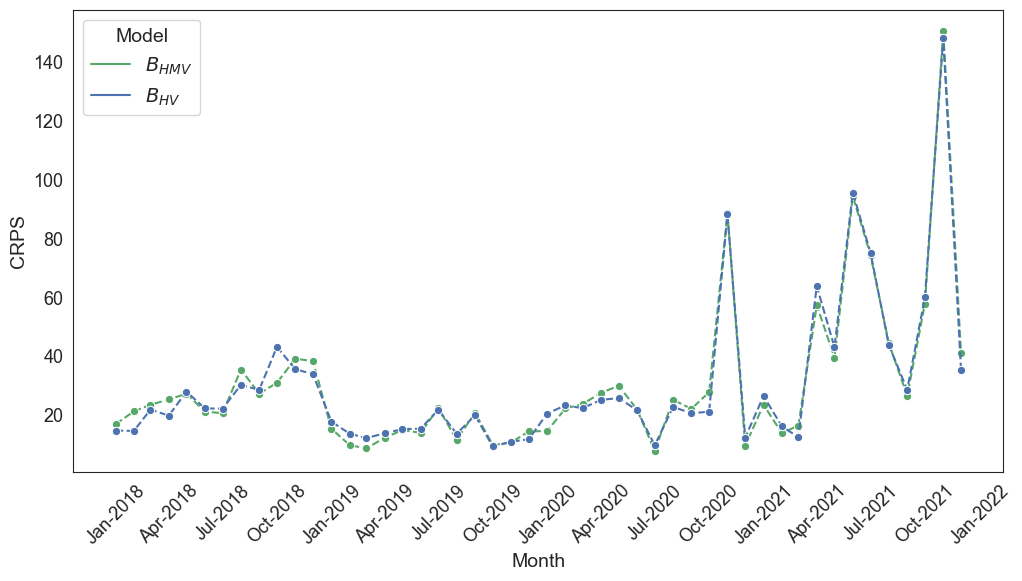

In [32]:
title = f'Average {score_info[score_index][1]} per Month'
plot_model_scores_scientific_labels(month_results_by_model, score_info[score_index][0], model_identifiers_subset3, model_scientific_identifiers_subset3, score_info[score_index][1], title, color_palette_str=color_string)

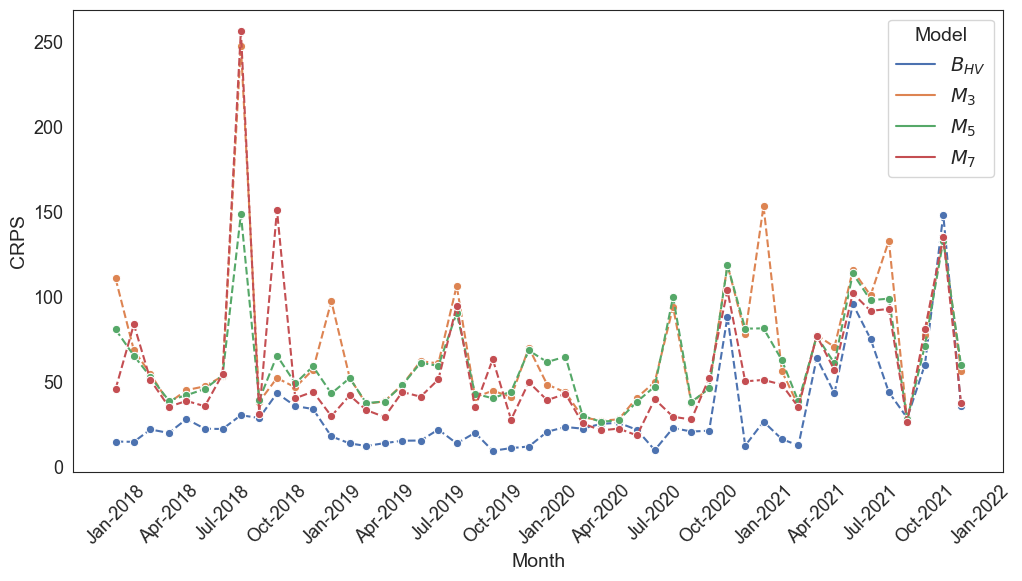

In [64]:
title = f'Average {score_info[score_index][1]} per Month'
plot_model_scores_scientific_labels(month_results_by_model, score_info[score_index][0], model_identifiers_subset, model_scientific_identifiers_subset, score_info[score_index][1], title, color_palette_str=color_string)

In [ ]:
title = f'Average {score_info[score_index][1]} per Month'
plot_model_scores_scientific_labels(month_results_by_model, score_info[score_index][0], model_identifiers_subset2, model_scientific_identifiers_subset2, score_info[score_index][1], title, color_palette_str=color_string)

**Boxplot of error metrics**

Boxplots of error metric for subset of countries: (i) all data (ii) truncated

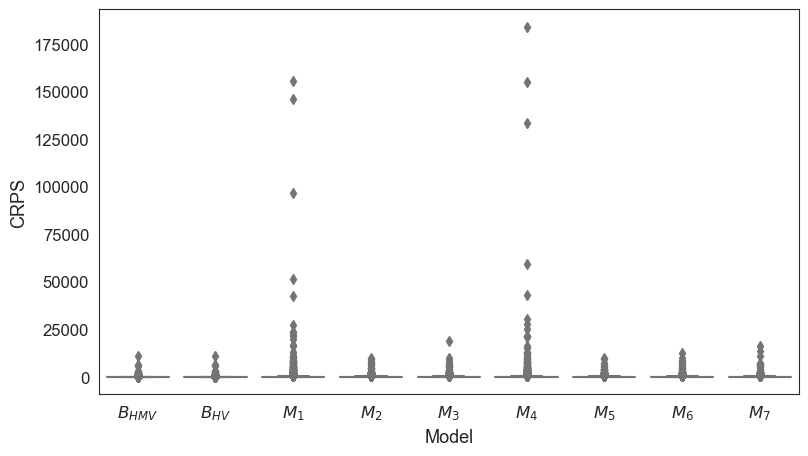

In [69]:
title = f'Boxplot of {score_info[score_index][1]} Scores by Model'
scientific_score = 'CRPS'
plot_aggregated_boxplots(metrics, score_info[score_index][0], model_identifiers_all, model_scientific_identifiers_all, scientific_score=scientific_score, color=default_blue_light, title=title, country_filter=feature_and_actuals_countries_non_zero)

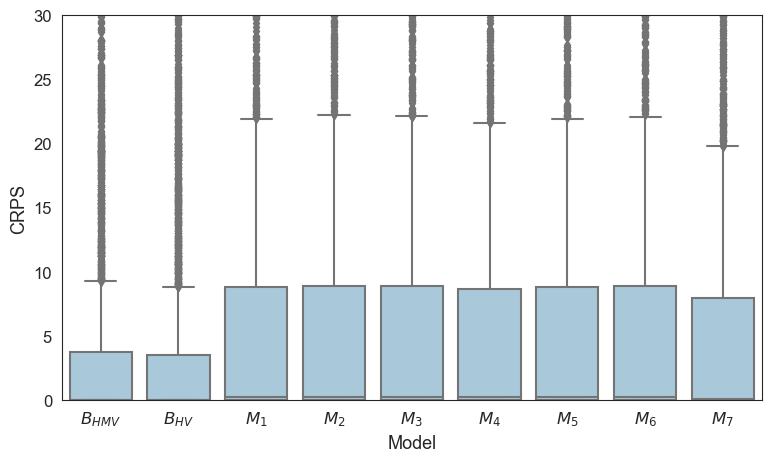

In [70]:
title = f'Boxplot of {score_info[score_index][1]} Scores by Model'
plot_aggregated_boxplots(metrics, score_info[score_index][0], model_identifiers_all, model_scientific_identifiers_all, scientific_score=scientific_score, color=default_blue_light, title=title, country_filter=feature_and_actuals_countries_non_zero, scale='truncated', truncation=30)

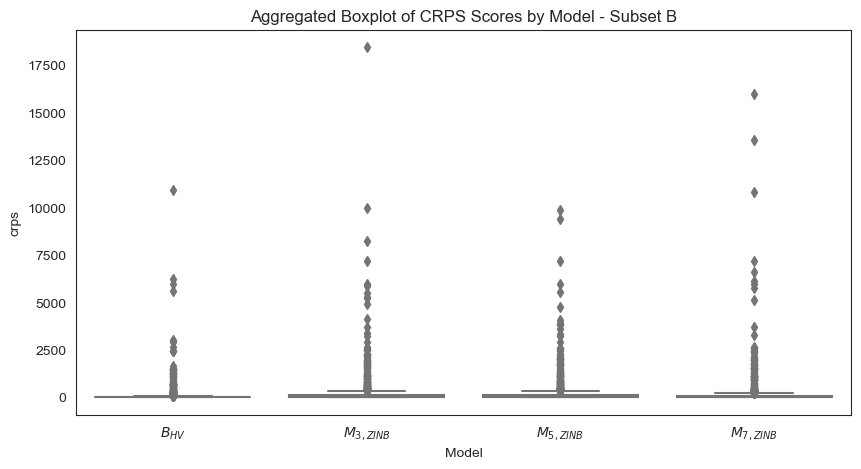

In [39]:
title = f'Boxplot of {score_info[score_index][1]} Scores by Model'
plot_aggregated_boxplots(metrics, score_info[score_index][0], model_identifiers_subset, model_scientific_identifiers_subset, scientific_score=score_info[score_index][0], color=default_blue_light, title=title,  fat_bigger_than=0, country_filter=feature_and_actuals_countries_non_zero)

In [ ]:
title = f'Aggregated Boxplot of {score_info[score_index][1]} Scores by Model - Subset B'
plot_aggregated_boxplots(metrics, score_info[score_index][0], model_identifiers_all, model_scientific_identifiers_all, scientific_score=score_info[score_index][0],  color=default_blue_light, title=title, fat_bigger_than=0, country_filter=feature_and_actuals_countries_non_zero, scale='truncated', truncation=650)

In [ ]:
title = f'Aggregated Boxplot of {score_info[score_index][1]} Scores by Model - Subset C'
plot_aggregated_boxplots(metrics, score_info[score_index][0], model_identifiers_all, model_scientific_identifiers_all,scientific_score= score_info[score_index][0], color=default_blue_light,title=title, fat_smaller_than=1, country_filter=feature_and_actuals_countries_non_zero)

In [ ]:
title=f'Aggregated Boxplot of {score_info[score_index][1]} Scores by Model - Subset C'
plot_aggregated_boxplots(metrics, score_info[score_index][0], model_identifiers_all, model_scientific_identifiers_all, scientific_score=score_info[score_index][0], color=default_blue_light, title=title, fat_smaller_than=1, country_filter=feature_and_actuals_countries_non_zero, scale='truncated', truncation=10)

#### Digging into the results

In [ ]:
metrics_formatted = metrics[metrics['model_identifier'] == heatmap_model]
# Apply the functions to map the IDs to names and dates
metrics_formatted['country_name'] = metrics_formatted['country_id'].apply(map_country_id_to_country_name)
metrics_formatted['date'] = metrics_formatted['month_id'].apply(map_month_id_to_datetime).dt.strftime('%B %Y')

# Optional: Merge month and year into a single column
# metrics_formatted['month_year'] = metrics_formatted['date'].apply(lambda x: x.strftime('%B %Y'))
# Column "ged_sb - crps -ratio" is the ratio of the number of fatalities to the crps score
metrics_formatted['ged_sb-crps-ratio'] = metrics_formatted['ged_sb'] / metrics_formatted['crps']

In [ ]:
metrics_no_training_countries = metrics[~metrics['country_id'].isin(feature_and_actuals_countries_non_zero)]; metrics_no_training_countries

In [ ]:
metrics_training_countries = metrics[metrics['country_id'].isin(feature_and_actuals_countries_non_zero)]

In [ ]:
metrics_training_countries[metrics_training_countries['crps'] < 10].quantile([0.5,0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

In [ ]:
# Quantiles of interest
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99]
# Compute the quantiles of the CRPS score (in column 'crps') for every model and return the results as a dataframe, with the quantiles as columns
quantiles_crps = metrics_training_countries.groupby('model_identifier')['crps'].quantile(quantiles).unstack(); quantiles_crps

In [ ]:
# Give percentage of values of CRPS score below 10, per model
below10 = metrics_training_countries[metrics_training_countries['crps'] < 10].groupby('model_identifier')['crps'].count() / metrics_training_countries.groupby('model_identifier')['crps'].count()
# Give percentage of values of CRPS score between 10 and 5000 per model
between10and500 = metrics_training_countries[(metrics_training_countries['crps'] >= 10) & (metrics_training_countries['crps'] < 10000)].groupby('model_identifier')['crps'].count() / metrics_training_countries.groupby('model_identifier')['crps'].count()
#Give percentage of values of CRPS score above 10000 per modeö
above500 = metrics_training_countries[metrics_training_countries['crps'] >= 10000].groupby('model_identifier')['crps'].count() / metrics_training_countries.groupby('model_identifier')['crps'].count()
# Determine the  maximum value of the CRPS score for each model
max_crps = metrics_training_countries.groupby('model_identifier')['crps'].max()
# Concatenate the three series into a dataframe with suitable column names
crps_percentages = pd.concat([below10, between10and500, above500, max_crps], axis=1)
crps_percentages.columns = ['below10', 'between10and10000', 'above10000', 'max']; crps_percentages

In [ ]:
# country names of prediction with crps above 10000
metrics_training_countries[metrics_training_countries['crps'] >= 5000]['country_id'].apply(map_country_id_to_country_name).unique()

### Analysing metric results based on quantiles

In [ ]:
# Calculate quantiles for each model
quantiles = month_country_results_by_model.groupby(['model', 'score_type']).quantile([0.25, 0.5, 0.75])
quantiles_actuals = month_country_results_by_model[month_country_results_by_model['country_id'].isin(feature_and_actuals_countries_non_zero)].groupby(['model', 'score_type']).quantile([0.25, 0.5, 0.75])
quantiles_actuals_above_avg_quantile = month_country_results_by_model[month_country_results_by_model['country_id'].isin(feature_and_actuals_countries_non_zero_above_avg_quantile)].groupby(['model', 'score_type']).quantile([0.25, 0.5, 0.75])

In [ ]:
# Calculate quantiles for each model and score over all monthns, years and countries
quantiles = month_country_results_by_model.groupby(['model', 'score_type']).quantile([0.25, 0.5, 0.75])

In [ ]:
quantiles_actuals

In [ ]:
quantiles_actuals_above_avg_quantile


In [ ]:
# Get the rows with the 100 highest crps scores for model1 and model4 and extract the corresponding country ids
model1_100_highest_crps = metrics[metrics['model_identifier'] == 'model1'].sort_values(by='crps', ascending=False).head(100)
model4_100_highest_crps = metrics[metrics['model_identifier'] == 'model4'].sort_values(by='crps', ascending=False).head(100)
model1_100_highest_crps_country_ids = model1_100_highest_crps['country_id'].unique()
model4_100_highest_crps_country_ids = model4_100_highest_crps['country_id'].unique()

In [ ]:
model1_100_highest_crps_country_names = [map_country_id_to_country_name(country_id) for country_id in model1_100_highest_crps_country_ids]
model4_100_highest_crps_country_names = [map_country_id_to_country_name(country_id) for country_id in model4_100_highest_crps_country_ids]

In [ ]:
# Compute the average fatalities for each country in the 100 highest crps scores for model1 and model4
model1_100_highest_crps_avg_fatalities = model1_100_highest_crps['ged_sb'].mean()
model4_100_highest_crps_avg_fatalities = model4_100_highest_crps['ged_sb'].mean()

In [ ]:
# Compute the 99th percentile of crps score for model1 and model4
model1_99th_percentile_crps = metrics[metrics['model_identifier'] == 'model1']['crps'].quantile(0.99)
model4_99th_percentile_crps = metrics[metrics['model_identifier'] == 'model4']['crps'].quantile(0.99)

In [ ]:
# Filter the dataframe on observations above the 99th percentile of crps score for model1 and model4
model1_above_99th_percentile_crps = metrics[(metrics['model_identifier'] == 'model1') & (metrics['crps'] > model1_99th_percentile_crps)]
model4_above_99th_percentile_crps = metrics[(metrics['model_identifier'] == 'model4') & (metrics['crps'] > model4_99th_percentile_crps)]

In [ ]:
# Extract the country ids for which the crps score is above the 99th percentile for model1 and model4
model1_99th_percentile_crps_country_ids = model1_above_99th_percentile_crps['country_id'].unique()
model4_99th_percentile_crps_country_ids = model4_above_99th_percentile_crps['country_id'].unique()
# Map those contry ids to their country names
model1_99th_percentile_crps_country_names = [map_country_id_to_country_name(country_id) for country_id in model1_99th_percentile_crps_country_ids]
model4_99th_percentile_crps_country_names = [map_country_id_to_country_name(country_id) for country_id in model4_99th_percentile_crps_country_ids]

In [ ]:
model1_100_highest_crps

In [ ]:
model4_above_99th_percentile_crps

In [ ]:
model1_above_99th_percentile_crps

In [ ]:
# Print some information that can be extracted from the 99th percentile of crps score for model1 and model4: 99th percentile of CRPS Score, Countries with crps score above 99th percentile, QUantiles of fatalities for countries with crps score above 99th percentile
print(f"99th percentile of CRPS Score for model1: \n {model1_99th_percentile_crps}")
print(f"99th percentile of CRPS Score for model4: \n {model4_99th_percentile_crps}")
print(f"Countries with crps score above 99th percentile for model1: \n {model1_99th_percentile_crps_country_names} of which 6 of 10 are within the top 10 countries")
print(f"Countries with crps score above 99th percentile for model4: \n {model4_99th_percentile_crps_country_names} of which 6 of 11 are within the top 10 countries")
print(f"Quantiles of fatalities for countries with crps score above 99th percentile for model1: \n {model1_above_99th_percentile_crps['ged_sb'].quantile([0.25, 0.5, 0.75])}")
print(f"Quantiles of fatalities for countries with crps score above 99th percentile for model4: \n {model4_above_99th_percentile_crps['ged_sb'].quantile([0.25, 0.5, 0.75])}")

In [ ]:
# Calculate the 99th percentile of crps score for each model
model1_99th_percentile_crps = metrics[metrics['model_identifier'] == 'model1']['crps'].quantile(0.99)
model2_99th_percentile_crps = metrics[metrics['model_identifier'] == 'model2']['crps'].quantile(0.99)
model3_99th_percentile_crps = metrics[metrics['model_identifier'] == 'model3']['crps'].quantile(0.99)
model4_99th_percentile_crps = metrics[metrics['model_identifier'] == 'model4']['crps'].quantile(0.99)
model5_99th_percentile_crps = metrics[metrics['model_identifier'] == 'model5']['crps'].quantile(0.99)


In [ ]:
# Calculate the mean of the CRPS score for every model excluding the obersations with a crps score above the models 99th percentile
model1_mean_crps_excluding_99th_percentile = metrics[(metrics['model_identifier'] == 'model1') & (metrics['crps'] <= model1_99th_percentile_crps)]['crps'].mean()
model2_mean_crps_excluding_99th_percentile = metrics[(metrics['model_identifier'] == 'model2') & (metrics['crps'] <= model2_99th_percentile_crps)]['crps'].mean()
model3_mean_crps_excluding_99th_percentile = metrics[(metrics['model_identifier'] == 'model3') & (metrics['crps'] <= model3_99th_percentile_crps)]['crps'].mean()
model4_mean_crps_excluding_99th_percentile = metrics[(metrics['model_identifier'] == 'model4') & (metrics['crps'] <= model4_99th_percentile_crps)]['crps'].mean()
model5_mean_crps_excluding_99th_percentile = metrics[(metrics['model_identifier'] == 'model5') & (metrics['crps'] <= model5_99th_percentile_crps)]['crps'].mean()
# Store them in a list
model_mean_crps_excluding_99th_percentile = [model1_mean_crps_excluding_99th_percentile, model2_mean_crps_excluding_99th_percentile, model3_mean_crps_excluding_99th_percentile, model4_mean_crps_excluding_99th_percentile, model5_mean_crps_excluding_99th_percentile]; model_mean_crps_excluding_99th_percentile

In [ ]:
# Calculate the quantiles of the crps scores fro each model
model5_crps_quantiles = metrics[metrics['model_identifier'] == 'model5']['crps'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
model2_crps_quantiles = metrics[metrics['model_identifier'] == 'model2']['crps'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
model1_crps_quantiles = metrics[metrics['model_identifier'] == 'model1']['crps'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
model3_crps_quantiles = metrics[metrics['model_identifier'] == 'model3']['crps'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
model4_crps_quantiles = metrics[metrics['model_identifier'] == 'model4']['crps'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
# Truncate the values to 4 decimals
model1_crps_quantiles = model1_crps_quantiles.round(4)
model2_crps_quantiles = model2_crps_quantiles.round(4)
model3_crps_quantiles = model3_crps_quantiles.round(4)
model4_crps_quantiles = model4_crps_quantiles.round(4)
model5_crps_quantiles = model5_crps_quantiles.round(4)

# Store the quantiles in a dataframe
model_crps_quantiles = pd.DataFrame({'model1': model1_crps_quantiles, 'model2': model2_crps_quantiles, 'model3': model3_crps_quantiles, 'model4': model4_crps_quantiles, 'model5': model5_crps_quantiles}); model_crps_quantiles


#### Experimental CDF PLots

In [ ]:
def cfd_plot(data, x, hue, xlim):
    plt.figure(figsize=(5, 5))
    # Gernate truncated cdf plot
    sns.ecdfplot(data=data, x=x, hue=hue)
    plt.title('CDF of CRPS Scores')
    if xlim != None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, data[x].max())

In [ ]:
# Plot the cdf of the crps scores which are greater than the model-specific crps median for each model into one plot
plt.figure(figsize=(15, 8))
sns.ecdfplot(data=metrics[metrics['model_identifier'] == 'model1'][metrics[metrics['model_identifier'] == 'model1']['crps'] > model1_crps_quantiles[0.9]], x='crps', color= sns.color_palette()[0], label='Model 1')
sns.ecdfplot(data=metrics[metrics['model_identifier'] == 'model2'][metrics[metrics['model_identifier'] == 'model2']['crps'] > model2_crps_quantiles[0.9]], x='crps', color= sns.color_palette()[1], label='Model 2')
sns.ecdfplot(data=metrics[metrics['model_identifier'] == 'model3'][metrics[metrics['model_identifier'] == 'model3']['crps'] > model3_crps_quantiles[0.9]], x='crps', color= sns.color_palette()[2], label='Model 3')
sns.ecdfplot(data=metrics[metrics['model_identifier'] == 'model4'][metrics[metrics['model_identifier'] == 'model4']['crps'] > model4_crps_quantiles[0.9]], x='crps', color= sns.color_palette()[3], label='Model 4')
sns.ecdfplot(data=metrics[metrics['model_identifier'] == 'model5'][metrics[metrics['model_identifier'] == 'model5']['crps'] > model5_crps_quantiles[0.9]], x='crps', color= sns.color_palette()[4], label='Model 5')
plt.title('CDF of CRPS Scores Greater than the Model-Specific CRPS Median')

In [ ]:
xlims= [None, 100000, 10000, 1000, 100, 10]
for xlim in xlims:
    cfd_plot(data=metrics, x='crps', hue='model_identifier', xlim=xlim)

In [ ]:
# Calculate the average crps scores and quantiles for each model for observations with 0 fatalities and store the results in a dataframe
zero_fatalities_metrics = pd.DataFrame(columns=['model_identifier', 'mean_crps', '25th_quantile_crps', '50th_quantile_crps', '75th_quantile_crps', '95th_quantile_crps', '99th_quantile_crps', 'max'])
for model_identifier in model_identifiers_all:
    mean_crps = metrics[(metrics['model_identifier'] == model_identifier) & (metrics['ged_sb'] == 0)]['crps'].mean()
    quantiles_crps = metrics[(metrics['model_identifier'] == model_identifier) & (metrics['ged_sb'] == 0)]['crps'].quantile([0.25, 0.5, 0.75, 0.95, 0.99])
    quantiles_crps = quantiles_crps.round(4)
    max_crps = metrics[(metrics['model_identifier'] == model_identifier) & (metrics['ged_sb'] == 0)]['crps'].max()
    zero_fatalities_metrics = zero_fatalities_metrics.append({'model_identifier': model_identifier, 'mean_crps': mean_crps, '25th_quantile_crps': quantiles_crps[0.25], '50th_quantile_crps': quantiles_crps[0.5], '75th_quantile_crps': quantiles_crps[0.75], '95th_quantile_crps': quantiles_crps[0.95], '99th_quantile_crps': quantiles_crps[0.99], 'max': max_crps}, ignore_index=True)

In [ ]:
zero_fatalities_metrics

In [62]:
from mappings import map_country_name_to_country_id, map_month_id_to_datetime

In [65]:
map_month_id_to_datetime(490)

datetime.datetime(2020, 10, 1, 0, 0)

In [64]:
map_country_name_to_country_id('Tanzania')

242